# Route time estimator

## Libraries

In [1]:
from typing import Any, Dict, List, Tuple, Optional
from dataclasses import dataclass

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
from geopy.distance import geodesic

import requests
from requests.adapters import HTTPAdapter

## Utility

In [2]:
RANDOM_STATE: int = 23

np.random.seed(RANDOM_STATE)

In [3]:
def plot_history(history):

    metrics = ["loss", "mean_absolute_error", "mean_squared_error",
               "root_mean_squared_error", "mean_absolute_percentage_error"]
    metric_labels = ["Loss", "MAE", "MSE", "RMSE", "MAPE"]

    plt.figure(figsize=(15, 10))

    for i, (metric, label) in enumerate(zip(metrics, metric_labels)):
        plt.subplot(2, 3, i + 1)  # Arrange in a 2x3 grid
        plt.plot(history.history[metric], label=f'Train {label}')
        if f'val_{metric}' in history.history:
            plt.plot(history.history[f'val_{metric}'], label=f'Val {label}')
        plt.xlabel('Epochs')
        plt.ylabel(label)
        plt.title(f'{label} History')
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()

In [4]:
def mean_signed_deviation_percentage(y_true: np.ndarray, y_pred: np.ndarray) -> np.float32:
    return np.mean((y_pred - y_true) / y_true)

mean_signed_deviation_percentage(np.array([1, 2, 3]), np.array([2, 2, 2]))

np.float64(0.22222222222222224)

In [5]:
import os
import json

RESULTS_PATH: str = './results/'

if not os.path.exists(RESULTS_PATH):
    os.makedirs(RESULTS_PATH)

VERSION: str = 'v2'
VERSION_PATH: str = os.path.join(RESULTS_PATH, VERSION)

if not os.path.exists(VERSION_PATH):
    os.makedirs(VERSION_PATH)

METRICS_PATH: str = os.path.join(VERSION_PATH, 'metrics')
if not os.path.exists(METRICS_PATH):
    os.makedirs(METRICS_PATH)

PLOT_PATH: str = os.path.join(VERSION_PATH, 'plots')
if not os.path.exists(PLOT_PATH):
    os.makedirs(PLOT_PATH)

MODEL_PATH: str = os.path.join(VERSION_PATH, 'models')
if not os.path.exists(MODEL_PATH):
    os.makedirs(MODEL_PATH)

In [6]:
AUGMENT_DATA = True
AUGMENTATION_ITER = 2
AUGMENTATION_PROB = 1.0

## Data

In [7]:
DATA_PATH = 'C:/Users/volpato/OneDrive - Cefriel/Desktop/P/FAE/db/'

### Shipments

In [8]:
orders_df = pd.read_csv(DATA_PATH + 'order.csv')
orders_df.head()

,id,manufacturer_id,manufacturer_order_id,site_id,carrier_id,status,n_steps,tracking_link,tracking_number,manufacturer_creation_timestamp,manufacturer_estimated_delivery_timestamp,manufacturer_confirmed_delivery_timestamp,carrier_creation_timestamp,carrier_estimated_delivery_timestamp,carrier_confirmed_delivery_timestamp,SLS,SRS
0,1,1,6004,8,1,DELIVERED,14,https://mydhl.express.dhl/it/it/tracking.html#...,1656325344,2025-01-07 07:31:00+00:00,2025-01-13 22:00:00+00:00,2025-01-17 11:36:00+00:00,2025-01-14T17:16+08:00,NaN,2025-01-17 10:40:00+00:00,0,0
1,2,1,6005,1,2,DELIVERED,11,1Z60699Y0400391867,1Z60699Y0400391867,2025-01-07 13:57:00+00:00,2025-01-08 22:00:00+00:00,2025-01-13 12:47:00+00:00,2025-01-09T03:11+00:00,NaN,2025-01-13 09:19:00+00:00,0,0
2,3,1,6037,3,2,DELIVERED,11,1ZR465910413218509,1ZR465910413218509,2025-01-10 13:41:00+00:00,2025-01-14 22:00:00+00:00,2025-01-15 09:18:00+00:00,2025-01-10T19:10-05:00,NaN,2025-01-15 09:47:00+00:00,0,0
3,4,1,6045,3,2,DELIVERED,12,https://www.digikey.it/OrderHistory/shipmenttr...,1ZR465910413219320,2025-01-13 15:27:00+00:00,2025-01-15 22:00:00+00:00,2025-01-15 09:45:00+00:00,2025-01-13T12:08-05:00,NaN,2025-01-15 09:47:00+00:00,0,0
4,5,1,6046,4,3,DELIVERED,14,https://www.fedex.com/fedextrack/?trknbr=43744...,437446419489,2025-01-13 15:27:00+00:00,2025-01-15 22:00:00+00:00,2025-01-15 12:14:00+00:00,2025-01-13T14:15-06:00,NaN,2025-01-15 11:49:00+00:00,0,0


In [9]:
orders_df.shape

(98, 17)

### Shipments steps

In [10]:
shipments_steps_df = pd.read_csv(DATA_PATH + 'order_steps_enriched.csv')
shipments_steps_df.head()

,order_id,step_source,timestamp_source,location_source,step_destination,timestamp_destination,location_destination,hours,geodesic_km,distance_road_km,time_road_no_traffic_hours,time_road_traffic_hours,wmi,tmi,transportation_mode
0,1,1,2025-01-14 09:16:00+00:00,"DONGGUAN, GUANGDONG, CN",2,2025-01-14 17:40:00+00:00,"DONGGUAN, GUANGDONG, CN",8.400000,0.000000,0.000,0.000000,0.000000,NaN,NaN,NONE
1,1,2,2025-01-14 17:40:00+00:00,"DONGGUAN, GUANGDONG, CN",3,2025-01-14 18:05:00+00:00,"DONGGUAN, GUANGDONG, CN",0.416667,0.000000,0.000,0.000000,0.000000,NaN,NaN,NONE
2,1,3,2025-01-14 18:05:00+00:00,"DONGGUAN, GUANGDONG, CN",4,2025-01-14 21:46:00+00:00,"SHENZHEN, GUANGDONG, CN",3.683333,61.761066,107.745,2.115278,2.115278,0.224436,0.0,ROAD
3,1,4,2025-01-14 21:46:00+00:00,"SHENZHEN, GUANGDONG, CN",5,2025-01-16 04:03:00+00:00,"SHENZHEN, GUANGDONG, CN",30.283333,0.000000,0.000,0.000000,0.000000,NaN,NaN,NONE
4,1,5,2025-01-16 04:03:00+00:00,"SHENZHEN, GUANGDONG, CN",6,2025-01-16 23:01:00+00:00,"BRUSSELS, BRUSSELS CAPITAL, BE",18.966667,9381.875452,0.000,0.000000,0.000000,0.750000,0.0,AIR


In [11]:
shipments_steps_df.head()

,order_id,step_source,timestamp_source,location_source,step_destination,timestamp_destination,location_destination,hours,geodesic_km,distance_road_km,time_road_no_traffic_hours,time_road_traffic_hours,wmi,tmi,transportation_mode
0,1,1,2025-01-14 09:16:00+00:00,"DONGGUAN, GUANGDONG, CN",2,2025-01-14 17:40:00+00:00,"DONGGUAN, GUANGDONG, CN",8.400000,0.000000,0.000,0.000000,0.000000,NaN,NaN,NONE
1,1,2,2025-01-14 17:40:00+00:00,"DONGGUAN, GUANGDONG, CN",3,2025-01-14 18:05:00+00:00,"DONGGUAN, GUANGDONG, CN",0.416667,0.000000,0.000,0.000000,0.000000,NaN,NaN,NONE
2,1,3,2025-01-14 18:05:00+00:00,"DONGGUAN, GUANGDONG, CN",4,2025-01-14 21:46:00+00:00,"SHENZHEN, GUANGDONG, CN",3.683333,61.761066,107.745,2.115278,2.115278,0.224436,0.0,ROAD
3,1,4,2025-01-14 21:46:00+00:00,"SHENZHEN, GUANGDONG, CN",5,2025-01-16 04:03:00+00:00,"SHENZHEN, GUANGDONG, CN",30.283333,0.000000,0.000,0.000000,0.000000,NaN,NaN,NONE
4,1,5,2025-01-16 04:03:00+00:00,"SHENZHEN, GUANGDONG, CN",6,2025-01-16 23:01:00+00:00,"BRUSSELS, BRUSSELS CAPITAL, BE",18.966667,9381.875452,0.000,0.000000,0.000000,0.750000,0.0,AIR


In [12]:
site_df: pd.DataFrame = pd.read_csv(DATA_PATH + 'site.csv')
site_df.head()

,id,supplier_id,location_name,n_rejections,n_orders,consider_closure_holidays,consider_working_holidays,consider_weekends_holidays
0,1,1,"LEEDS, ENGLAND, GB",0,5,True,True,True
1,2,2,"LOUISVILLE, KENTUCKY, US",0,3,True,True,True
2,3,2,"THIEF RIVER FALLS, MINNESOTA, US",0,61,True,True,True
3,4,3,"GRAND PRAIRIE, TEXAS, US",0,5,True,True,True
4,5,4,"MONTAGNOLA, TICINO, CH",0,1,True,True,True


In [13]:
vertex_df: pd.DataFrame = pd.read_csv(DATA_PATH + 'vertex.csv')
vertex_df.head()

,id,name,type
0,1,"HO CHI MINH CITY, HO CHI MINH, VN",INTERMEDIATE
1,2,"CASTLE DONINGTON, ENGLAND, GB",INTERMEDIATE
2,3,"SHENZHEN, GUANGDONG, CN",INTERMEDIATE
3,4,"ZHUHAI, GUANGDONG, CN",INTERMEDIATE
4,5,"DONGGUAN, GUANGDONG, CN",INTERMEDIATE


In [14]:
ori_df: pd.DataFrame = pd.read_csv(DATA_PATH + 'ori.csv')
ori_df.head()

,id,vertex_id,created_at,hours
0,1,5,2025-08-21T14:05:19+00:00,0.416667
1,2,3,2025-08-21T14:05:19+00:00,30.283333
2,3,33,2025-08-21T14:05:19+00:00,0.016667
3,4,43,2025-08-21T14:05:19+00:00,3.016667
4,5,28,2025-08-21T14:05:19+00:00,1.766667


In [15]:
avg_ori_df = ori_df.groupby('vertex_id')['hours'].mean().reset_index()
avg_ori_df.head()

,vertex_id,hours
0,1,1.416667
1,2,5.791667
2,3,10.050000
3,5,0.416667
4,8,2.733333


In [16]:
oti_df: pd.DataFrame = pd.read_csv(DATA_PATH + 'oti.csv')
oti_df.head()

,id,source_id,destination_id,created_at,hours
0,1,9,5,2025-08-21T14:05:36+00:00,8.400000
1,2,5,3,2025-08-21T14:05:36+00:00,3.683333
2,3,3,33,2025-08-21T14:05:36+00:00,18.966667
3,4,33,43,2025-08-21T14:05:36+00:00,1.983333
4,5,43,28,2025-08-21T14:05:36+00:00,1.450000


In [17]:
oti_dist_df: pd.DataFrame = oti_df.groupby(['source_id', 'destination_id'])['hours'].agg(
    [
        'mean',
        'std',
        ('q1', lambda x: x.quantile(0.25)),
        ('median', 'median'),
        ('q3', lambda x: x.quantile(0.75)),
        'min',
        'max',
        'count'
    ]).reset_index()    # type: ignore                  

oti_dist_df.head()

,source_id,destination_id,mean,std,q1,median,q3,min,max,count
0,1,32,4.883333,NaN,4.883333,4.883333,4.883333,4.883333,4.883333,1
1,2,39,0.554167,0.442923,0.325000,0.408333,0.637500,0.200000,1.200000,4
2,3,32,2.333333,0.714920,1.820833,2.133333,2.820833,1.583333,3.383333,6
3,3,33,18.966667,NaN,18.966667,18.966667,18.966667,18.966667,18.966667,1
4,4,62,26.916667,NaN,26.916667,26.916667,26.916667,26.916667,26.916667,1


In [18]:
wmi_df: pd.DataFrame = pd.read_csv(DATA_PATH + 'wmi.csv')
wmi_df.head()

,id,source_id,destination_id,timestamp,created_at,n_interpolation_points,step_distance_km,value
0,0,5,3,2025-01-14T21:46+00:00,2025-08-21T14:05:42+00:00,2,200.00000,0.224436
1,1,3,33,2025-01-16T18:16+00:00,2025-08-21T14:05:42+00:00,5,2345.47108,0.750000
2,2,33,43,2025-01-16T23:44+00:00,2025-08-21T14:05:42+00:00,4,200.00000,0.101561
3,3,43,28,2025-01-17T05:20+00:00,2025-08-21T14:05:42+00:00,5,200.00000,0.119203
4,4,28,22,2025-01-17T07:15+00:00,2025-08-21T14:05:42+00:00,2,200.00000,0.103400


In [19]:
avg_wmi_df = wmi_df.groupby(['source_id', 'destination_id'])['value'].mean().reset_index()
avg_wmi_df.head()

,source_id,destination_id,value
0,1,32,0.083173
1,2,39,0.188180
2,3,32,0.041285
3,3,33,0.750000
4,4,62,0.401312


In [20]:
tmi_df: pd.DataFrame = pd.read_csv(DATA_PATH + 'tmi.csv')
tmi_df.head()

,id,source_id,destination_id,timestamp,created_at,transportation_mode,value
0,1,5,3,2025-01-14 18:05:00+00:00,2025-08-21T14:05:51+00:00,ROAD,0.000000
1,2,28,22,2025-01-17 07:15:00+00:00,2025-08-21T14:05:51+00:00,ROAD,0.148400
2,3,22,38,2025-01-17 08:28:00+00:00,2025-08-21T14:05:51+00:00,ROAD,0.240227
3,4,60,2,2025-01-09 18:30:00+00:00,2025-08-21T14:05:51+00:00,ROAD,0.055454
4,5,11,14,2025-01-10 05:55:00+00:00,2025-08-21T14:05:51+00:00,ROAD,0.183163


In [21]:
avg_tmi_df = tmi_df.groupby(['source_id', 'destination_id'])['value'].mean().reset_index()
avg_tmi_df.head()

,source_id,destination_id,value
0,3,32,0.003969
1,4,62,0.000000
2,5,3,0.000000
3,5,62,0.000000
4,7,25,0.002091


## Dataset

In [22]:
def start_session() -> requests.Session:
    session = requests.Session()
    session.headers.update({
        "Connection": "keep-alive",
        "Accept-Encoding": "gzip, deflate",
        "User-Agent": "GeoApiGateway/1.0",
    })

    adapter = HTTPAdapter(
        pool_connections=10, 
        pool_maxsize=10, 
        pool_block=True
        )
    
    session.mount("http://", adapter)
    session.mount("https://", adapter)

    return session

def end_session(session: requests.Session) -> None:
    session.close()

session = start_session()
session.close()

In [23]:
geonames_usernames = ["ifoxz17", "ifoxz18", "ifoxz19"]
GEONAMES_USERNAME = geonames_usernames[0]

def get_location_info(city_name: str, api_key: str, session: Optional[requests.Session] = None) -> Optional[Tuple[float, float]]:
    url = f"http://api.geonames.org/searchJSON?q={city_name}&maxRows=1&username={api_key}"

    try:
        response = (session or requests).get(url, timeout=5)
        response.raise_for_status()
        data = response.json()

        if (not data) or ("geonames" not in data) or (not data["geonames"]):
            print(f"GeoNames response for '{city_name}' is empty or invalid")
            return None

        city_data: Dict = data["geonames"][0]
        lat: float = city_data["lat"]
        lon: float = city_data["lng"]

        return lat, lon

    except requests.RequestException as e:
        print(f"Request error for '{city_name}': {e}")
    except Exception as e:
        print(f"Unexpected error for '{city_name}': {e}")

    return None


get_location_info("San Diego", GEONAMES_USERNAME)

('32.71571', '-117.16472')

In [24]:
LOCATION_CACHE: Dict[str, Tuple[float, float]] = {}

In [25]:
lat_source_data: List[float] = []
lon_source_data: List[float] = []
lat_dest_data: List[float] = []
lon_dest_data: List[float] = []

j: int = 0
session: requests.Session = start_session()

for i, row in tqdm(shipments_steps_df.iterrows(), total=shipments_steps_df.shape[0]):
    location_source: str = row['location_source']
    if "HONG KONG" in location_source:
        location_source = "HONG KONG"

    result: Optional[Tuple[float, float]] = LOCATION_CACHE.get(location_source) or get_location_info(location_source, geonames_usernames[j], session)
    if result is None:
        print(f"Failed to get location for source city: {location_source}")
        continue
    
    s_lat, s_lon = result
    if not location_source in LOCATION_CACHE:
        LOCATION_CACHE[location_source] = (s_lat, s_lon)
    lat_source_data.append(s_lat)
    lon_source_data.append(s_lon)


    location_destination: str = row['location_destination']
    if "HONG KONG" in location_destination:
        location_destination = "HONG KONG"
    result: Optional[Tuple[float, float]] = LOCATION_CACHE.get(location_destination) or get_location_info(location_destination, geonames_usernames[j], session)
    if result is None:
        print(f"Failed to get location for destination city: {location_destination}")
        continue

    d_lat, d_lon = result
    if not location_destination in LOCATION_CACHE:
        LOCATION_CACHE[location_destination] = (d_lat, d_lon)
    lat_dest_data.append(d_lat)
    lon_dest_data.append(d_lon)

    j = (j + 1) % len(geonames_usernames)
    
end_session(session)

shipments_steps_df.insert(7, 'longitude_destination', lon_dest_data)
shipments_steps_df.insert(7, 'latitude_destination', lat_dest_data)

shipments_steps_df.insert(4, 'longitude_source', lon_source_data)
shipments_steps_df.insert(4, 'latitude_source', lat_source_data)

assert shipments_steps_df['latitude_source'].notnull().all(), "Some source latitudes are null"
assert shipments_steps_df['longitude_source'].notnull().all(), "Some source longitudes are null"
assert shipments_steps_df['latitude_destination'].notnull().all(), "Some destination latitudes are null"
assert shipments_steps_df['longitude_destination'].notnull().all(), "Some destination longitudes are null"

distance_data = shipments_steps_df.apply(
    lambda row: geodesic(
        (row['latitude_source'], row['longitude_source']),
        (row['latitude_destination'], row['longitude_destination'])
    ).km, axis=1
)

shipments_steps_df.head()

100%|██████████| 936/936 [00:04<00:00, 217.22it/s]


,order_id,step_source,timestamp_source,location_source,latitude_source,longitude_source,step_destination,timestamp_destination,location_destination,latitude_destination,longitude_destination,hours,geodesic_km,distance_road_km,time_road_no_traffic_hours,time_road_traffic_hours,wmi,tmi,transportation_mode
0,1,1,2025-01-14 09:16:00+00:00,"DONGGUAN, GUANGDONG, CN",23.01797,113.74866,2,2025-01-14 17:40:00+00:00,"DONGGUAN, GUANGDONG, CN",23.01797,113.74866,8.400000,0.000000,0.000,0.000000,0.000000,NaN,NaN,NONE
1,1,2,2025-01-14 17:40:00+00:00,"DONGGUAN, GUANGDONG, CN",23.01797,113.74866,3,2025-01-14 18:05:00+00:00,"DONGGUAN, GUANGDONG, CN",23.01797,113.74866,0.416667,0.000000,0.000,0.000000,0.000000,NaN,NaN,NONE
2,1,3,2025-01-14 18:05:00+00:00,"DONGGUAN, GUANGDONG, CN",23.01797,113.74866,4,2025-01-14 21:46:00+00:00,"SHENZHEN, GUANGDONG, CN",22.54554,114.0683,3.683333,61.761066,107.745,2.115278,2.115278,0.224436,0.0,ROAD
3,1,4,2025-01-14 21:46:00+00:00,"SHENZHEN, GUANGDONG, CN",22.54554,114.0683,5,2025-01-16 04:03:00+00:00,"SHENZHEN, GUANGDONG, CN",22.54554,114.0683,30.283333,0.000000,0.000,0.000000,0.000000,NaN,NaN,NONE
4,1,5,2025-01-16 04:03:00+00:00,"SHENZHEN, GUANGDONG, CN",22.54554,114.0683,6,2025-01-16 23:01:00+00:00,"BRUSSELS, BRUSSELS CAPITAL, BE",50.85045,4.34878,18.966667,9381.875452,0.000,0.000000,0.000000,0.750000,0.0,AIR


In [26]:
df = shipments_steps_df.loc[:,
                                [
                                'order_id',
                                'step_source', 'location_source', 'latitude_source', 'longitude_source',
                                'step_destination', 'location_destination', 'latitude_destination', 'longitude_destination',
                                'geodesic_km',
                                'wmi', 'tmi', 'transportation_mode',
                                'hours'
                                ]
                            ]
df.head()

,order_id,step_source,location_source,latitude_source,longitude_source,step_destination,location_destination,latitude_destination,longitude_destination,geodesic_km,wmi,tmi,transportation_mode,hours
0,1,1,"DONGGUAN, GUANGDONG, CN",23.01797,113.74866,2,"DONGGUAN, GUANGDONG, CN",23.01797,113.74866,0.000000,NaN,NaN,NONE,8.400000
1,1,2,"DONGGUAN, GUANGDONG, CN",23.01797,113.74866,3,"DONGGUAN, GUANGDONG, CN",23.01797,113.74866,0.000000,NaN,NaN,NONE,0.416667
2,1,3,"DONGGUAN, GUANGDONG, CN",23.01797,113.74866,4,"SHENZHEN, GUANGDONG, CN",22.54554,114.0683,61.761066,0.224436,0.0,ROAD,3.683333
3,1,4,"SHENZHEN, GUANGDONG, CN",22.54554,114.0683,5,"SHENZHEN, GUANGDONG, CN",22.54554,114.0683,0.000000,NaN,NaN,NONE,30.283333
4,1,5,"SHENZHEN, GUANGDONG, CN",22.54554,114.0683,6,"BRUSSELS, BRUSSELS CAPITAL, BE",50.85045,4.34878,9381.875452,0.750000,0.0,AIR,18.966667


In [27]:
routes_data: List[Dict[str, Any]] = []
points_data: List[Dict[str, Any]] = []

for i, row in df.iterrows():
    order_id: int = row['order_id']
    source: str = row['location_source']
    destination: str = row['location_destination']
    
    step_source: int = row['step_source']
    step_destination: int = row['step_destination']
    n_steps: int = orders_df[orders_df['id'] == order_id]['n_steps'].values[0]

    if source == destination and step_source == 1:
        print(f"Skipping row {i} with source=destination={destination}, step_source={step_source}")
        continue

    if row['hours'] == 0:
        print('Skipping row {} with no time with source={}, destination={}, step_source={}'.format(i, source, destination, step_source))
        continue

    v_id: int
    if step_source == 1:
        site_id: int = orders_df.loc[orders_df['id'] == order_id, 'site_id'].values[0]
        v_df: pd.DataFrame = vertex_df.loc[(vertex_df['name'] == str(site_id)) & (vertex_df['type'] == 'SUPPLIER_SITE')]
        assert len(v_df) == 1, f"Expected one vertex for site_id {site_id}, found {len(v_df)}"
        v: pd.Series = v_df.iloc[0]
        assert v['type'] == 'SUPPLIER_SITE'
        v_id: int = v['id']
    else:
        v_df: pd.DataFrame = vertex_df.loc[vertex_df['name'] == source]
        assert len(v_df) == 1, f"Expected one vertex for vertx {source}, found {len(v_df)}"
        v: pd.Series = v_df.iloc[0]
        assert v['type'] == 'INTERMEDIATE'
        v_id: int = v['id']

    u_id: int
    if step_destination == n_steps:
        manufacturer_id: int = orders_df.loc[orders_df['id'] == order_id, 'manufacturer_id'].values[0]
        u_df: pd.DataFrame = vertex_df.loc[(vertex_df['name'] == str(manufacturer_id)) & (vertex_df['type'] == 'MANUFACTURER')]
        assert len(u_df) == 1, f"Expected one vertex for manufacturer_id {manufacturer_id}, found {len(u_df)}"
        u: pd.Series = u_df.iloc[0]
        assert u['type'] == 'MANUFACTURER'
        u_id: int = u['id']
    else:
        u_df: pd.DataFrame = vertex_df.loc[vertex_df['name'] == destination]
        assert len(u_df) == 1, f"Expected one vertex for vertex {destination}, found {len(u_df)}"
        u: pd.Series = u_df.iloc[0]
        assert u['type'] == 'INTERMEDIATE'
        u_id: int = u['id']

    entry = []
    if v_id != u_id:
        avg_oti_entry: pd.DataFrame = oti_dist_df.loc[(oti_dist_df['source_id'] == v_id) & (oti_dist_df['destination_id'] == u_id)]
        if avg_oti_entry.empty:
            print(f"No average OTI entry found for source_id {v_id} ({v['name']}) and destination_id {u_id} ({u['name']})")
            avg_oti: float = 0.0
        else:
            assert len(avg_oti_entry) == 1, f"Expected one average OTI entry for source_id {v_id} and destination_id {u_id}, found {len(avg_oti_entry)}"    
            avg_oti: float = avg_oti_entry['mean'].values[0]

        avg_wmi_entry: pd.DataFrame = avg_wmi_df.loc[(avg_wmi_df['source_id'] == v_id) & (avg_wmi_df['destination_id'] == u_id)]
        if avg_wmi_entry.empty:
            print(f"No average wmi entry found for source_id {v_id} ({v['name']}) and destination_id {u_id} ({u['name']})")
            avg_wmi: float = 0.0
        else:
            assert len(avg_wmi_entry) == 1, f"Expected one average wmi entry for source_id {v_id} and destination_id {u_id}, found {len(avg_wmi_entry)}"
            avg_wmi: float = avg_wmi_entry['value'].values[0]
        
        avg_tmi_entry: pd.DataFrame = avg_tmi_df.loc[(avg_tmi_df['source_id'] == v_id) & (avg_tmi_df['destination_id'] == u_id)]
        if avg_tmi_entry.empty:
            print(f"No average TMI entry found for source_id {v_id} {v['name']} and destination_id {u_id} {u['name']}")
            avg_tmi: float = 0.0
        else:
            assert len(avg_tmi_entry) == 1, f"Expected one average TMI entry for source_id {v_id} and destination_id {u_id}, found {len(avg_tmi_entry)}"
            avg_tmi: float = avg_tmi_entry['value'].values[0]

        routes_data.append({
            'source_id': v_id, 'source': source, 'step_source': step_source,
            'latitude_source': float(row['latitude_source']), 'longitude_source': float(row['longitude_source']),
            'destination_id': u_id, 'destination': destination, 'step_destination': step_destination,
            'n_steps': n_steps,
            'latitude_destination': float(row['latitude_destination']), 'longitude_destination': float(row['longitude_destination']),
            'distance': float(row['geodesic_km']),
            'avg_wmi': avg_wmi, 'wmi': row['wmi'],
            'avg_tmi': avg_tmi, 'tmi': float(row['tmi']), 'transportation_mode': row['transportation_mode'],
            'avg_oti': avg_oti, 'time': float(row['hours'])
        })
    else:
        assert source == destination
        avg_ori_entry: pd.DataFrame = avg_ori_df.loc[avg_ori_df['vertex_id'] == v_id]
        if avg_ori_entry.empty:
            print(f"No average ORI entry found for vertex_id {v_id} ({v['name']})")
            avg_ori: float = 0.0
        else:
            assert len(avg_ori_entry) == 1, f"Expected one average ORI entry for vertex_id {v_id} ({v['name']}), found {len(avg_ori_entry)}"
            avg_ori: float = avg_ori_entry['hours'].values[0] if not avg_ori_entry.empty else 0.0
        
        points_data.append({
            'location': source,
            'latitude_source': float(row['latitude_source']), 'longitude_source': float(row['longitude_source']),
            'latitude_destination': float(row['latitude_destination']), 'longitude_destination': float(row['longitude_destination']),
            'avg_ori': avg_ori,
            'time': float(row['hours'])
        })

routes_df: pd.DataFrame = pd.DataFrame(routes_data)
points_df: pd.DataFrame = pd.DataFrame(points_data)

routes_df.shape, points_df.shape

Skipping row 0 with source=destination=DONGGUAN, GUANGDONG, CN, step_source=1
No average TMI entry found for source_id 3 SHENZHEN, GUANGDONG, CN and destination_id 33 BRUSSELS, BRUSSELS CAPITAL, BE
No average TMI entry found for source_id 33 BRUSSELS, BRUSSELS CAPITAL, BE and destination_id 43 LEIPZIG, SAXONY, DE
No average TMI entry found for source_id 43 LEIPZIG, SAXONY, DE and destination_id 28 BRESCIA, LOMBARDY, IT
No average wmi entry found for source_id 22 (BERGAMO, LOMBARDY, IT) and destination_id 48 (1)
No average TMI entry found for source_id 22 BERGAMO, LOMBARDY, IT and destination_id 48 1
Skipping row 13 with source=destination=LEEDS, ENGLAND, GB, step_source=1
No average TMI entry found for source_id 2 CASTLE DONINGTON, ENGLAND, GB and destination_id 39 COLOGNE, NORTH RHINE-WESTPHALIA, DE
No average TMI entry found for source_id 39 COLOGNE, NORTH RHINE-WESTPHALIA, DE and destination_id 11 SERIATE, LOMBARDY, IT
No average wmi entry found for source_id 14 (TREVIOLO, LOMBARDY,

((483, 19), (371, 7))

#### Routes

In [28]:
routes_df.head()

,source_id,source,step_source,latitude_source,longitude_source,destination_id,destination,step_destination,n_steps,latitude_destination,longitude_destination,distance,avg_wmi,wmi,avg_tmi,tmi,transportation_mode,avg_oti,time
0,5,"DONGGUAN, GUANGDONG, CN",3,23.01797,113.74866,3,"SHENZHEN, GUANGDONG, CN",4,14,22.54554,114.06830,61.761066,0.224436,0.224436,0.000000,0.0000,ROAD,3.683333,3.683333
1,3,"SHENZHEN, GUANGDONG, CN",5,22.54554,114.06830,33,"BRUSSELS, BRUSSELS CAPITAL, BE",6,14,50.85045,4.34878,9381.875452,0.750000,0.750000,0.000000,0.0000,AIR,18.966667,18.966667
2,33,"BRUSSELS, BRUSSELS CAPITAL, BE",7,50.85045,4.34878,43,"LEIPZIG, SAXONY, DE",8,14,51.33962,12.37129,564.352543,0.101561,0.101561,0.000000,0.0000,AIR,1.983333,1.983333
3,43,"LEIPZIG, SAXONY, DE",9,51.33962,12.37129,28,"BRESCIA, LOMBARDY, IT",10,14,45.53558,10.21472,664.754853,0.231342,0.119203,0.000000,0.0000,AIR,1.860000,1.450000
4,28,"BRESCIA, LOMBARDY, IT",11,45.53558,10.21472,22,"BERGAMO, LOMBARDY, IT",12,14,45.69601,9.66721,46.277438,0.106983,0.103400,0.093648,0.1484,ROAD,0.944792,0.733333


Sanity check:

In [29]:
assert len(routes_df[routes_df['avg_oti'] == 0]) == 0
assert len(routes_df[routes_df['time'] == 0]) == 0

##### Outliers removal

In [30]:
q1_by_route: Dict[Tuple[int, int], float] = {}
q3_by_route: Dict[Tuple[int, int], float] = {}

for i, row in oti_dist_df.iterrows():
    source_id: int = row['source_id']
    destination_id: int = row['destination_id']
    q1_by_route[(source_id, destination_id)] = row['q1']
    q3_by_route[(source_id, destination_id)] = row['q3']

assert len(q1_by_route) == len(oti_dist_df)
assert len(q3_by_route) == len(oti_dist_df)

In [31]:
index_to_remove: List[Any] = []
for i, row in routes_df.iterrows():
    v_id: int = row['source_id']
    u_id: int = row['destination_id']
    
    q1: float = q1_by_route[(v_id, u_id)]
    q3: float = q3_by_route[(v_id, u_id)]
    iqr: float = q3 - q1
    lower_bound: float = q1 - 1. * iqr
    upper_bound: float = q3 + 1. * iqr
    if row['time'] < lower_bound or row['time'] > upper_bound:
        index_to_remove.append(i)

print(f"Number of outliers to remove: {len(index_to_remove)}")

routes_df: pd.DataFrame = routes_df.drop(index_to_remove).reset_index(drop=True)
routes_df.shape

Number of outliers to remove: 42


(441, 19)

In [32]:
routes_df[(routes_df['avg_wmi'].isna() | (routes_df['avg_wmi'] <= 0))]

,source_id,source,step_source,latitude_source,longitude_source,destination_id,destination,step_destination,n_steps,latitude_destination,longitude_destination,distance,avg_wmi,wmi,avg_tmi,tmi,transportation_mode,avg_oti,time
5,22,"BERGAMO, LOMBARDY, IT",13,45.69601,9.66721,48,"GAZZANIGA, LOMBARDY, IT",14,14,45.79339,9.82976,16.647969,0.0,0.086274,0.0,0.240227,ROAD,2.996875,2.200000
9,14,"TREVIOLO, LOMBARDY, IT",10,45.67368,9.61195,48,"GAZZANIGA, LOMBARDY, IT",11,11,45.79339,9.82976,21.550816,0.0,0.167982,0.0,0.034006,ROAD,6.434444,4.466667
13,14,"TREVIOLO, LOMBARDY, IT",10,45.67368,9.61195,48,"GAZZANIGA, LOMBARDY, IT",11,11,45.79339,9.82976,21.550816,0.0,0.144303,0.0,0.028242,ROAD,6.434444,4.983333
18,14,"TREVIOLO, LOMBARDY, IT",11,45.67368,9.61195,48,"GAZZANIGA, LOMBARDY, IT",12,12,45.79339,9.82976,21.550816,0.0,0.144303,0.0,0.209222,ROAD,6.434444,3.750000
25,35,"GRASSOBBIO, LOMBARDY, IT",13,45.65688,9.72565,48,"GAZZANIGA, LOMBARDY, IT",14,14,45.79339,9.82976,17.201432,0.0,0.141851,0.0,0.130048,ROAD,2.862500,3.533333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
419,14,"TREVIOLO, LOMBARDY, IT",11,45.67368,9.61195,48,"GAZZANIGA, LOMBARDY, IT",12,12,45.79339,9.82976,21.550816,0.0,0.151871,0.0,0.035735,ROAD,6.434444,10.950000
424,14,"TREVIOLO, LOMBARDY, IT",10,45.67368,9.61195,48,"GAZZANIGA, LOMBARDY, IT",11,11,45.79339,9.82976,21.550816,0.0,0.115067,0.0,0.027089,ROAD,6.434444,7.816667
429,14,"TREVIOLO, LOMBARDY, IT",10,45.67368,9.61195,48,"GAZZANIGA, LOMBARDY, IT",11,11,45.79339,9.82976,21.550816,0.0,0.137051,0.0,0.094524,ROAD,6.434444,9.716667
434,14,"TREVIOLO, LOMBARDY, IT",10,45.67368,9.61195,48,"GAZZANIGA, LOMBARDY, IT",11,11,45.79339,9.82976,21.550816,0.0,0.137051,0.0,0.094524,ROAD,6.434444,9.716667


In [33]:
assert len(routes_df[(routes_df['wmi'].isna() | (routes_df['wmi'] <= 0))]) == 0
#assert len(routes_df[(routes_df['avg_wmi'].isna() | (routes_df['avg_wmi'] <= 0))]) == 0

In [34]:
assert len(routes_df[routes_df['tmi'].isna()]) == 0
assert len(routes_df[routes_df['avg_tmi'].isna()]) == 0

In [35]:
routes_df['wmi'] = routes_df['wmi'].fillna(0.0)
routes_df = routes_df[~ (
    ((routes_df['wmi'] == 0) & (routes_df['tmi'] == 0))
)]

assert not routes_df['wmi'].isna().any(), "There are still NaN values in wmi"
assert not routes_df['tmi'].isna().any(), "There are still NaN values in TMI"
assert len(routes_df[(routes_df['tmi'] == 0) & (routes_df['wmi'] == 0)]) == 0, "There are routes with both TMI and wmi equal to 0"
routes_df = routes_df.reset_index(drop=True)

routes_df.head()

,source_id,source,step_source,latitude_source,longitude_source,destination_id,destination,step_destination,n_steps,latitude_destination,longitude_destination,distance,avg_wmi,wmi,avg_tmi,tmi,transportation_mode,avg_oti,time
0,5,"DONGGUAN, GUANGDONG, CN",3,23.01797,113.74866,3,"SHENZHEN, GUANGDONG, CN",4,14,22.54554,114.06830,61.761066,0.224436,0.224436,0.000000,0.0000,ROAD,3.683333,3.683333
1,3,"SHENZHEN, GUANGDONG, CN",5,22.54554,114.06830,33,"BRUSSELS, BRUSSELS CAPITAL, BE",6,14,50.85045,4.34878,9381.875452,0.750000,0.750000,0.000000,0.0000,AIR,18.966667,18.966667
2,33,"BRUSSELS, BRUSSELS CAPITAL, BE",7,50.85045,4.34878,43,"LEIPZIG, SAXONY, DE",8,14,51.33962,12.37129,564.352543,0.101561,0.101561,0.000000,0.0000,AIR,1.983333,1.983333
3,43,"LEIPZIG, SAXONY, DE",9,51.33962,12.37129,28,"BRESCIA, LOMBARDY, IT",10,14,45.53558,10.21472,664.754853,0.231342,0.119203,0.000000,0.0000,AIR,1.860000,1.450000
4,28,"BRESCIA, LOMBARDY, IT",11,45.53558,10.21472,22,"BERGAMO, LOMBARDY, IT",12,14,45.69601,9.66721,46.277438,0.106983,0.103400,0.093648,0.1484,ROAD,0.944792,0.733333


Number of instances of the same route:

In [36]:
routes_count_df: pd.DataFrame = pd.DataFrame(routes_df.groupby(['source', 'destination']).size(), columns=['count'])
routes_count_df

,,count
source,destination,
"BALERNA, TICINO, CH","LONATE POZZOLO, LOMBARDY, IT",1
"BERGAMO, LOMBARDY, IT","GAZZANIGA, LOMBARDY, IT",12
"BOCA RATON, FLORIDA, US","NEW YORK, NEW YORK, US",1
"BRATISLAVA, BRATISLAVA REGION, SK","LEIPZIG, SAXONY, DE",1
"BRESCIA, LOMBARDY, IT","BERGAMO, LOMBARDY, IT",15
"BRUSSELS, BRUSSELS CAPITAL, BE","LEIPZIG, SAXONY, DE",1
"CASTLE DONINGTON, ENGLAND, GB","COLOGNE, NORTH RHINE-WESTPHALIA, DE",3
"CINCINNATI, OHIO, US","LEIPZIG, SAXONY, DE",2
"COLOGNE, NORTH RHINE-WESTPHALIA, DE","LEIPZIG, SAXONY, DE",1


In [37]:
routes_agg_df: pd.DataFrame = routes_df.groupby(['source', 'destination'])['time'].aggregate(['count', 'mean', 'median', 'std']).reset_index().sort_values(by='count', ascending=False)
routes_agg_df['cv'] = routes_agg_df['std'] / routes_agg_df['mean']
routes_agg_df

,source,destination,count,mean,median,std,cv
56,"TREVIOLO, LOMBARDY, IT","GAZZANIGA, LOMBARDY, IT",60,6.434444,6.333333,2.374018,0.368955
51,"SERIATE, LOMBARDY, IT","TREVIOLO, LOMBARDY, IT",55,0.407576,0.100000,0.627932,1.540651
9,"COLOGNE, NORTH RHINE-WESTPHALIA, DE","SERIATE, LOMBARDY, IT",50,1.235000,1.250000,0.119724,0.096943
34,"LOUISVILLE, KENTUCKY, US","COLOGNE, NORTH RHINE-WESTPHALIA, DE",49,7.613265,7.583333,0.192510,0.025286
54,"THIEF RIVER FALLS, MINNESOTA, US","FARGO, NORTH DAKOTA, US",31,9.367742,7.650000,13.232636,1.412575
13,"FARGO, NORTH DAKOTA, US","LOUISVILLE, KENTUCKY, US",27,3.085802,3.066667,0.094925,0.030762
55,"THIEF RIVER FALLS, MINNESOTA, US","LOUISVILLE, KENTUCKY, US",17,4.459804,4.233333,0.685263,0.153653
30,"LEIPZIG, SAXONY, DE","BRESCIA, LOMBARDY, IT",15,1.860000,1.950000,0.369298,0.198547
4,"BRESCIA, LOMBARDY, IT","BERGAMO, LOMBARDY, IT",15,0.927778,0.950000,0.108501,0.116947
32,"LONATE POZZOLO, LOMBARDY, IT","GRASSOBBIO, LOMBARDY, IT",12,5.754167,4.016667,4.309293,0.748900


In [57]:
routes_to_corr_df: pd.DataFrame = routes_df[['avg_tmi', 'tmi', 'avg_wmi', 'wmi', 'avg_oti', 'time']].copy()
routes_to_corr_df['delta_tmi'] = abs(routes_to_corr_df['tmi'] - routes_to_corr_df['avg_tmi']) ** 2
routes_to_corr_df['delta_wmi'] = abs(routes_to_corr_df['wmi'] - routes_to_corr_df['avg_wmi']) ** 2
routes_to_corr_df['delta_time'] = abs(routes_to_corr_df['time'] - routes_to_corr_df['avg_oti']) ** 2
routes_to_corr_df = routes_to_corr_df[['tmi', 'delta_tmi', 'wmi', 'delta_wmi', 'avg_oti', 'time', 'delta_time']]

routes_to_corr_df.head()

,tmi,delta_tmi,wmi,delta_wmi,avg_oti,time,delta_time
0,0.0000,0.000000,0.224436,0.000000,3.683333,3.683333,0.000000
1,0.0000,0.000000,0.750000,0.000000,18.966667,18.966667,0.000000
2,0.0000,0.000000,0.101561,0.000000,1.983333,1.983333,0.000000
3,0.0000,0.000000,0.119203,0.012575,1.860000,1.450000,0.168100
4,0.1484,0.002998,0.103400,0.000013,0.944792,0.733333,0.044715


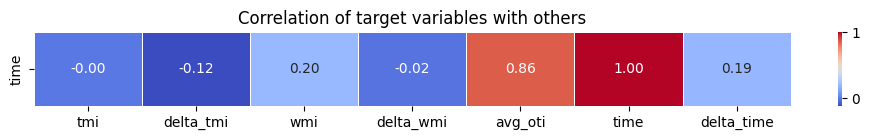

In [58]:
routes_corr_df = routes_to_corr_df.corr(method='spearman')
time_corr_row = routes_corr_df.loc[['time']]

# Plot the heatmap
plt.figure(figsize=(10, 1.5))  # Wide and short to emphasize a row
sns.heatmap(time_corr_row, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation of target variables with others")
plt.tight_layout()
plt.savefig(os.path.join(VERSION_PATH, 'time_correlation_heatmap.png'))
plt.show()


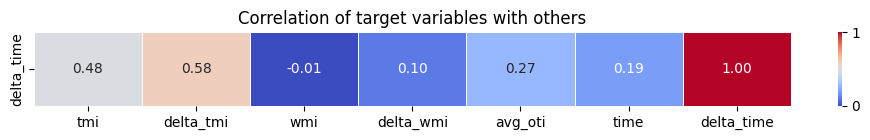

In [59]:
routes_corr_df = routes_to_corr_df.corr(method='spearman')
time_corr_row = routes_corr_df.loc[['delta_time']]

# Plot the heatmap
plt.figure(figsize=(10, 1.5))  # Wide and short to emphasize a row
sns.heatmap(time_corr_row, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation of target variables with others")
plt.tight_layout()
plt.savefig(os.path.join(VERSION_PATH, 'time_correlation_heatmap.png'))
plt.show()


##### Data augmentation

In [1482]:
routes_df.head()

,source_id,source,step_source,latitude_source,longitude_source,destination_id,destination,step_destination,n_steps,latitude_destination,longitude_destination,distance,avg_wmi,wmi,avg_tmi,tmi,transportation_mode,avg_oti,time
0,63,"DONGGUAN, GUANGDONG, CN",3,23.01797,113.74866,39,"SHENZHEN, GUANGDONG, CN",4,14,22.54554,114.06830,61.761066,0.224436,0.224436,0.000000,0.00000,ROAD,3.683333,3.683333
1,39,"SHENZHEN, GUANGDONG, CN",5,22.54554,114.06830,20,"BRUSSELS, BRUSSELS CAPITAL, BE",6,14,50.85045,4.34878,9381.875452,0.750000,0.750000,0.000000,0.00000,AIR,18.966667,18.966667
2,20,"BRUSSELS, BRUSSELS CAPITAL, BE",7,50.85045,4.34878,19,"LEIPZIG, SAXONY, DE",8,14,51.33962,12.37129,564.352543,0.101561,0.101561,0.000000,0.00000,AIR,1.983333,1.983333
3,19,"LEIPZIG, SAXONY, DE",9,51.33962,12.37129,40,"BRESCIA, LOMBARDY, IT",10,14,45.53558,10.21472,664.754853,0.231342,0.119203,0.000000,0.00000,AIR,1.860000,1.450000
4,40,"BRESCIA, LOMBARDY, IT",11,45.53558,10.21472,58,"BERGAMO, LOMBARDY, IT",12,14,45.69601,9.66721,46.277438,0.106983,0.103400,0.094904,0.14811,ROAD,0.944792,0.733333


In [1483]:
random.seed(RANDOM_STATE)

augmented_routes_data: List[Dict[str, Any]] = []
rows_skipped, rows_unusable = [], []

if AUGMENT_DATA:
    for i, row in tqdm(routes_df.iloc[:-1, :].iterrows(), total=len(routes_df) - 1):
        next_row = routes_df.loc[i + 1, :]              # type: ignore
        if row['destination'] != next_row['source']:
            rows_unusable.append(i)
            continue

        if random.random() > AUGMENTATION_PROB:
            rows_skipped.append(i)
            continue

        augmented_distance = row['distance'] + next_row['distance']
        augmented_routes_data.append({ 
            "source": row['source'], "step_source": row['step_source'],
            "latitude_source": float(row['latitude_source']), "longitude_source": float(row['longitude_source']),
            "destination": next_row['destination'], "step_destination": next_row['step_destination'],
            "latitude_destination": next_row['latitude_destination'], "longitude_destination": next_row['longitude_destination'],
            "distance": float(augmented_distance),
            "avg_wmi": (row['avg_wmi'] * row['distance'] + next_row['avg_wmi'] * next_row['distance']) / augmented_distance,
            "wmi": (row['wmi'] * row['distance'] + next_row['wmi'] * next_row['distance']) / augmented_distance,
            "avg_tmi": (row['avg_tmi'] * row['distance'] + next_row['avg_tmi'] * next_row['distance']) / augmented_distance,
            "tmi": (row['tmi'] * row['distance'] + next_row['tmi'] * next_row['distance']) / augmented_distance,
            "transportation_mode_source": row['transportation_mode'],
            "trasnportation_mode_destination": next_row['transportation_mode'],
            "avg_oti": row['avg_oti'] + next_row['avg_oti'],
            "time": float(row['time'] + next_row['time'])
        })

augmented_routes_df: pd.DataFrame = pd.DataFrame(augmented_routes_data)
augmented_routes_df.head()

100%|██████████| 440/440 [00:00<00:00, 3082.97it/s]


,source,step_source,latitude_source,longitude_source,destination,step_destination,latitude_destination,longitude_destination,distance,avg_wmi,wmi,avg_tmi,tmi,transportation_mode_source,trasnportation_mode_destination,avg_oti,time
0,"DONGGUAN, GUANGDONG, CN",3,23.01797,113.74866,"BRUSSELS, BRUSSELS CAPITAL, BE",6,50.85045,4.34878,9443.636517,0.746563,0.746563,0.000000,0.000000,ROAD,AIR,22.650000,22.650000
1,"SHENZHEN, GUANGDONG, CN",5,22.54554,114.06830,"LEIPZIG, SAXONY, DE",8,51.33962,12.37129,9946.227995,0.713207,0.713207,0.000000,0.000000,AIR,AIR,20.950000,20.950000
2,"BRUSSELS, BRUSSELS CAPITAL, BE",7,50.85045,4.34878,"BRESCIA, LOMBARDY, IT",10,45.53558,10.21472,1229.107397,0.171752,0.111102,0.000000,0.000000,AIR,AIR,3.843333,3.433333
3,"LEIPZIG, SAXONY, DE",9,51.33962,12.37129,"BERGAMO, LOMBARDY, IT",12,45.69601,9.66721,711.032292,0.223248,0.118174,0.006177,0.009640,AIR,ROAD,2.804792,2.183333
4,"BRESCIA, LOMBARDY, IT",11,45.53558,10.21472,"GAZZANIGA, LOMBARDY, IT",14,45.79339,9.82976,62.925407,0.078679,0.098869,0.069796,0.170181,ROAD,ROAD,3.941667,2.933333


In [1484]:
routes_df.shape[0], augmented_routes_df.shape[0], len(rows_skipped), len(rows_unusable)

(441, 324, 0, 116)

In [1485]:
random.seed(RANDOM_STATE)

second_level_augmented_routes_data: List[Dict[str, Any]] = []
rows_skipped, rows_unusable = [], []

if AUGMENTATION_ITER == 2:
    for i, row in tqdm(routes_df.iloc[:-2, :].iterrows(), total=len(routes_df) - 2):
        next_row = routes_df.loc[i + 1, :]
        next_next_row = routes_df.loc[i + 2, :]
        if row['destination'] != next_row['source'] or next_row['destination'] != next_next_row['source']:
            rows_unusable.append(i)
            continue

        if random.random() > AUGMENTATION_PROB:
            rows_skipped.append(i)
            continue

        augmented_distance = row['distance'] + next_row['distance'] + next_next_row['distance']
        second_level_augmented_routes_data.append({ 
            "source": row['source'], "step_source": row['step_source'],
            "latitude_source": float(row['latitude_source']), "longitude_source": float(row['longitude_source']),
            "destination": next_next_row['destination'], "step_destination": next_next_row['step_destination'],
            "latitude_destination": next_next_row['latitude_destination'], "longitude_destination": next_next_row['longitude_destination'],
            "distance": float(augmented_distance),
            "avg_wmi": (row['avg_wmi'] * row['distance'] + next_row['avg_wmi'] * next_row['distance'] + next_next_row['avg_wmi'] * next_next_row['distance']) / augmented_distance,
            "wmi": (row['wmi'] * row['distance'] + next_row['wmi'] * next_row['distance'] + next_next_row['wmi'] * next_next_row['distance']) / augmented_distance,
            "avg_tmi": (row['avg_tmi'] * row['distance'] + next_row['avg_tmi'] * next_row['distance'] + next_next_row['avg_tmi'] * next_next_row['distance']) / augmented_distance,
            "tmi": (row['tmi'] * row['distance'] + next_row['tmi'] * next_row['distance'] + next_next_row['tmi'] * next_next_row['distance']) / augmented_distance,
            "transportation_mode_1": row['transportation_mode'],
            "trasnportation_mode_2": next_row['transportation_mode'],
            "transportation_mode_3": next_next_row['transportation_mode'],
            "avg_oti": row['avg_oti'] + next_row['avg_oti'] + next_next_row['avg_oti'],
            "time": float(row['time'] + next_row['time'] + next_next_row['time'])
        })


second_level_augmented_routes_df: pd.DataFrame = pd.DataFrame(second_level_augmented_routes_data)
second_level_augmented_routes_df.head()

100%|██████████| 439/439 [00:00<00:00, 2246.21it/s]


,source,step_source,latitude_source,longitude_source,destination,step_destination,latitude_destination,longitude_destination,distance,avg_wmi,wmi,avg_tmi,tmi,transportation_mode_1,trasnportation_mode_2,transportation_mode_3,avg_oti,time
0,"DONGGUAN, GUANGDONG, CN",3,23.01797,113.74866,"LEIPZIG, SAXONY, DE",8,51.33962,12.37129,10007.989061,0.710191,0.710191,0.000000,0.000000,ROAD,AIR,AIR,24.633333,24.633333
1,"SHENZHEN, GUANGDONG, CN",5,22.54554,114.06830,"BRESCIA, LOMBARDY, IT",10,45.53558,10.21472,10610.982848,0.683020,0.675994,0.000000,0.000000,AIR,AIR,AIR,22.810000,22.400000
2,"BRUSSELS, BRUSSELS CAPITAL, BE",7,50.85045,4.34878,"BERGAMO, LOMBARDY, IT",12,45.69601,9.66721,1275.384835,0.169402,0.110823,0.003444,0.005374,AIR,AIR,ROAD,4.788125,4.166667
3,"LEIPZIG, SAXONY, DE",9,51.33962,12.37129,"GAZZANIGA, LOMBARDY, IT",14,45.79339,9.82976,727.680260,0.218141,0.117445,0.006036,0.014716,AIR,ROAD,ROAD,5.801667,4.383333
4,"COLOGNE, NORTH RHINE-WESTPHALIA, DE",6,50.93333,6.95000,"GAZZANIGA, LOMBARDY, IT",11,45.79339,9.82976,649.121002,0.199322,0.488977,0.000399,0.002425,AIR,ROAD,ROAD,8.270000,5.483333


In [1486]:
routes_df.shape[0], second_level_augmented_routes_df.shape[0], len(rows_skipped), len(rows_unusable)

(441, 226, 0, 213)

In [1487]:
augmented_routes_df = pd.concat([augmented_routes_df, second_level_augmented_routes_df], ignore_index=True)
augmented_routes_df.shape

(550, 20)

#### Points

In [1488]:
points_df.head()

,location,latitude_source,longitude_source,latitude_destination,longitude_destination,avg_ori,time
0,"DONGGUAN, GUANGDONG, CN",23.01797,113.74866,23.01797,113.74866,0.416667,0.416667
1,"SHENZHEN, GUANGDONG, CN",22.54554,114.06830,22.54554,114.06830,10.050000,30.283333
2,"BRUSSELS, BRUSSELS CAPITAL, BE",50.85045,4.34878,50.85045,4.34878,0.016667,0.016667
3,"LEIPZIG, SAXONY, DE",51.33962,12.37129,51.33962,12.37129,14.585417,3.016667
4,"BRESCIA, LOMBARDY, IT",45.53558,10.21472,45.53558,10.21472,1.486458,1.766667


In [1489]:
points_agg_df = points_df.groupby(['location'])['time'].aggregate(['count', 'mean', 'median', 'std']).reset_index().sort_values(by='count', ascending=False)
points_agg_df['cv'] = points_agg_df['std'] / points_agg_df['mean']
points_agg_df.head()

,location,count,mean,median,std,cv
8,"COLOGNE, NORTH RHINE-WESTPHALIA, DE",61,22.671858,9.316667,29.390150,1.296327
33,"TREVIOLO, LOMBARDY, IT",60,1.860556,0.383333,9.095084,4.888370
30,"SERIATE, LOMBARDY, IT",57,1.875439,1.683333,0.594586,0.317038
22,"LOUISVILLE, KENTUCKY, US",51,7.179739,4.150000,10.162568,1.415451
19,"LEIPZIG, SAXONY, DE",16,14.585417,5.450000,19.594797,1.343451


## Models

In [1490]:
TRAIN_SIZE = 0.7
TEST_SIZE = 0.2
VALIDATION_SIZE = 1 - TRAIN_SIZE - TEST_SIZE

EPSILON = 1e-6
assert abs(TRAIN_SIZE + VALIDATION_SIZE + TEST_SIZE - 1.0) < EPSILON

### Routes

#### Utility functions 

In [1491]:
from sklearn.metrics import mean_absolute_error as MAE, root_mean_squared_error as RMSE, mean_absolute_percentage_error as MAPE

@dataclass(frozen=True)
class EvaluationResult:
    mae: float
    rmse: float
    mape: float
    msdp: float

def evaluate_model(y_true: np.ndarray, y_pred: np.ndarray, model_name: str, dataset_name: str) -> EvaluationResult:
    mae: float = MAE(y_true, y_pred)
    rmse: float = RMSE(y_true, y_pred)
    mape: float = MAPE(y_true, y_pred)
    msdp: float = float(mean_signed_deviation_percentage(y_true, y_pred))
    
    print(f"\n{model_name} Results:")
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAPE: {mape:.4f}")
    print(f"MSDP: {msdp:.4f}")

    with open(os.path.join(METRICS_PATH, f"{model_name}_{dataset_name}_evaluation.json"), 'w') as f:
        json.dump({
            "MAE": mae,
            "RMSE": rmse,
            "MAPE": mape,
            "MSDP": msdp
        }, f, indent=4)
    
    return EvaluationResult(mae=mae, rmse=rmse, mape=mape, msdp=msdp)

In [1492]:
from sklearn.model_selection import train_test_split

@dataclass(frozen=True)
class DataSplit:
    X_train: pd.DataFrame
    X_val: pd.DataFrame
    X_test: pd.DataFrame

    y_train: pd.Series
    y_val: pd.Series
    y_test: pd.Series

def split_data(
    X: pd.DataFrame, 
    y: pd.Series,
    test_size: float = TEST_SIZE,
    validation_size: float = VALIDATION_SIZE,
    random_state: int = RANDOM_STATE
) -> DataSplit:
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, 
        test_size=test_size, 
        random_state=random_state
    )
    
    val_size_relative: float = validation_size / (1 - test_size)
    
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val,
        test_size=val_size_relative,
        random_state=random_state
    )
    
    return DataSplit(
        X_train=X_train,
        X_val=X_val,
        X_test=X_test,
        y_train=y_train,
        y_val=y_val,
        y_test=y_test
    )

In [1493]:
def concat_augmented_data(split: DataSplit,
                          X_augmented: pd.DataFrame, 
                          y_augmented: pd.Series,
                          random_state: int = RANDOM_STATE
                          ) -> DataSplit:
    

    X_train = pd.concat([split.X_train, X_augmented], axis=0).sample(frac=1, random_state=random_state).reset_index(drop=True)
    y_train = pd.concat([split.y_train, y_augmented], axis=0).sample(frac=1, random_state=random_state).reset_index(drop=True)

    return DataSplit(
        X_train=X_train,
        X_val=split.X_val,
        X_test=split.X_test,
        y_train=y_train,
        y_val=split.y_val,
        y_test=split.y_test
    )


In [1494]:
from sklearn.preprocessing import MinMaxScaler

@dataclass(frozen=True)
class TrainableDataSplit:
    X_train: np.ndarray
    X_val: np.ndarray
    X_test: np.ndarray

    y_train: np.ndarray
    y_val: np.ndarray
    y_test: np.ndarray

def normalize_data(split: DataSplit, normalize: bool = False) -> TrainableDataSplit:
    if not normalize:
        return TrainableDataSplit(
            X_train=split.X_train.to_numpy(),
            X_val=split.X_val.to_numpy(),
            X_test=split.X_test.to_numpy(),
            y_train=split.y_train.to_numpy(),
            y_val=split.y_val.to_numpy(),
            y_test=split.y_test.to_numpy()
        )
    
    scaler: MinMaxScaler = MinMaxScaler()
    scaler.fit(split.X_train)

    X_train_norm: np.ndarray = scaler.transform(split.X_train)
    X_val_norm: np.ndarray = scaler.transform(split.X_val)
    X_test_norm: np.ndarray = scaler.transform(split.X_test)
    
    return TrainableDataSplit(
        X_train=X_train_norm,
        X_val=X_val_norm,
        X_test=X_test_norm,
        y_train=split.y_train.to_numpy(),
        y_val=split.y_val.to_numpy(),
        y_test=split.y_test.to_numpy()
    )

##### Evaluation

In [1495]:
def evaluate_metrics_by_route_count(y_true: np.ndarray, y_pred:np.ndarray, routes_count: List[int]) -> pd.DataFrame:
    rmse_by_route_count = []
    mae_by_route_count = []
    mape_by_route_count = []

    for i, count in enumerate(routes_count):
        y_true_val, y_pred_val = y_true[i], y_pred[i]
        rmse_by_route_count.append(RMSE(np.array([y_true_val]), np.array([y_pred_val])))
        mae_by_route_count.append(MAE(np.array([y_true_val]), np.array([y_pred_val])))
        mape_by_route_count.append(MAPE(np.array([y_true_val]), np.array([y_pred_val])))

    metrics_by_route_count_df = pd.DataFrame(
        {
            'count': routes_count,
            'MAE': mae_by_route_count,
            'RMSE': rmse_by_route_count,
            'MAPE': mape_by_route_count
        })

    return metrics_by_route_count_df

In [1496]:
def plot_predictions(y_true: np.ndarray, y_pred: np.ndarray, model_name: str, dataset_name: str) -> None:
    plt.figure(figsize=(12, 5))
    plt.plot(y_true, label='True Values', marker='o', linestyle='', color='green')
    plt.plot(y_pred, label=f'{model_name} Predictions', marker='x', linestyle='', color='blue')
    
    for i in range(len(y_true)):
        y_true_val = y_true[i]
        plt.vlines(x=i, ymin=y_true_val, ymax=y_pred[i], color='red', linestyle='--', linewidth=0.8)
    
    plt.xlabel('Sample Index')
    plt.ylabel('Time [hours]')
    plt.title(f'True vs Predicted Time  ({model_name} - {dataset_name})')
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(PLOT_PATH, f"{model_name}_{dataset_name}_predictions.png"))
    plt.show()

In [1497]:
def plot_metrics_comparison(results_list: List[List[EvaluationResult]], models_list: List[List[str]], dataset_name: str, dataset_index: int =-1) -> None:
    # Extract metrics from results
    mae_values = [eval.mae for eval in results_list[dataset_index]]
    rmse_values = [result.rmse for result in results_list[dataset_index]]
    mape_values = [result.mape for result in results_list[dataset_index]]

    # Plot the metrics
    x = range(len(models_list[dataset_index]))  # Indices for the models

    plt.figure(figsize=(12, 6))

    # Plot MAE
    plt.plot(x, mae_values, label='MAE', marker='o', linestyle='-', color='blue')
    plt.axhline(y=mae_values[0], color='gray', linestyle='--')

    # Plot RMSE
    plt.plot(x, rmse_values, label='RMSE', marker='s', linestyle='-', color='green')
    plt.axhline(y=rmse_values[0], color='gray', linestyle='--')

    # Plot MAPE
    plt.plot(x, mape_values, label='MAPE', marker='^', linestyle='-', color='red')
    plt.axhline(y=mape_values[0], color='gray', linestyle='--')

    # Add labels and title
    plt.xticks(x, models_list[dataset_index], rotation=45)
    plt.xlabel('Models')
    plt.ylabel('Metric Values')
    plt.title(f'Comparison of Metrics Across Models ({dataset_name})')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    plt.savefig(os.path.join(PLOT_PATH, f"metrics_comparison_{dataset_name}.png"))
    plt.show()

##### Models

Dummy model

In [1498]:
DUMMY_MODEL_NAME: str = "Dummy model"

Linear regression

In [1499]:
LR_MODEL_NAME: str = "Linear Regression"

In [1500]:
from sklearn.linear_model import LinearRegression

def train_linear_regression(X_train: np.ndarray, y_train: np.ndarray,
                            X_val: np.ndarray, y_val: np.ndarray,
                            random_state: int = RANDOM_STATE) -> LinearRegression:
    lr_model: LinearRegression = LinearRegression()
    lr_model.fit(X_train, y_train)

    return lr_model

Random Forest Regressor

In [1501]:
RFR_MODEL_NAME: str = "Random Forest"

In [1502]:
from sklearn.ensemble import RandomForestRegressor

def train_random_forest(X_train: np.ndarray, y_train: np.ndarray,
                        X_val: np.ndarray, y_val: np.ndarray, 
                        random_state: int = RANDOM_STATE) -> RandomForestRegressor:
    
    # Initialize the Random Forest Regressor
    rf_model: RandomForestRegressor = RandomForestRegressor(
        criterion='absolute_error',  
        n_estimators=100,
        max_depth=10,
        min_samples_split=2,                # Minimum number of samples required to split a node.
        min_samples_leaf=1,                 # Minimum number of samples required to be at a leaf node.
        max_leaf_nodes=None,                # Maximum number of leaf nodes per tree. If None, then unlimited number of leaf nodes.
        bootstrap=True,                     # Whether to bootstrap samples when building trees. If False, the whole dataset is used to build each tree.
        max_samples=0.8,                    # If bootstrapping is enabled, it controls the fraction of samples drawn for each tree.
        oob_score=True,                     # Out-of-Bag score: if true, it uses the samples left out by bootstrapping to estimate the model’s performance.
        max_features='sqrt',                # Number of features considered for each split.
        n_jobs=-1,                          # Number of jobs to run in parallel. -1 means using all processors.
        verbose=0,
        random_state=random_state
    )

    X_train_val: np.ndarray = np.concatenate((X_train, X_val), axis=0)
    y_train_val: np.ndarray = np.concatenate((y_train, y_val), axis=0)

    rf_model.fit(X_train_val, y_train_val)
    return rf_model

XGBoost

In [1503]:
XGB_MODEL_NAME: str = "XGBoost"

In [1504]:
from xgboost import Booster, DMatrix, train as xgb_train

def train_xgb(X_train: np.ndarray, y_train: np.ndarray,
              X_val: np.ndarray, y_val: np.ndarray, 
              random_state: int = RANDOM_STATE) -> Booster:
    
    # Create the DMatrix for XGBoost
    dtrain = DMatrix(X_train, label=y_train)
    dval = DMatrix(X_val, label=y_val)

    params = {
        'objective': 'reg:absoluteerror',
        'booster': 'gbtree',                # gbtree, gblinear or dart
        'max_depth': 8,                     # Maximum depth of a tree
        'min_child_weight': 3,              # Minimum sum of instance weight (hessian) needed in a child.
        'gamma': 0.1,                       # Minimum loss reduction required to make a further partition on a leaf node of the tree.
        'eta': 0.1,                         # Learning rate
        'subsample': 0.8,                   # Subsample ratio of the training instances.
        'colsample_bytree': 0.8,            # Subsample ratio of columns when constructing each tree.
        'lambda': 0.1,                      # L2 regularization term on weights
        'alpha': 0.0,                       # L1 regularization term on weights
        'seed': random_state,               # Random seed for reproducibility
    }

    # Train the model
    num_rounds = 1000
    xgb_model: Booster = xgb_train(params, dtrain, num_rounds, evals=[(dval, 'eval')], early_stopping_rounds=100)
    return xgb_model

LightGBM

In [1505]:
GBM_MODEL_NAME: str = "LightGBM"

In [1506]:
import lightgbm as lgb

def train_lgb(X_train: np.ndarray, y_train: np.ndarray, 
              X_val: np.ndarray, y_val: np.ndarray,
              random_state: int = RANDOM_STATE
              ) -> lgb.Booster:
    # Create the LightGBM datasets
    train_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

    params = {
        'objective': 'regression',
        'metric': 'mae',
        'boosting_type': 'gbdt',

        # Improved structure control
        'num_leaves': 31,                # Controls complexity; start with 31
        'max_depth': -1,                 # Let LGBM choose the depth (unbounded), or set e.g., 6–10 for control

        # Regularization to reduce overfitting
        'lambda_l2': 1.0,                # Stronger regularization
        'lambda_l1': 0.1,

        # Data sampling to improve generalization
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,

        # Training dynamics
        'learning_rate': 0.05,           # Slower learning, better generalization
        'min_data_in_leaf': 20,          # Avoids small leaves (can be tuned)
        'min_gain_to_split': 0.01,       # Minimum gain to make a split (a form of regularization)

        # Misc
        'seed': random_state,
        'verbose': -1
    }

    # Train the model
    num_rounds = 1000
    lgb_model = lgb.train(
        params,
        train_data,
        num_boost_round=num_rounds,
        valid_sets=[val_data],
        valid_names=['eval'],
        callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=True)]
    )
    return lgb_model

#### Initialization

In [1507]:
metrics: Tuple[str, str, str] = ('MAE', 'RMSE', 'MAPE')

datasets: List[str] = []
results: List[List[EvaluationResult]] = []
models: List[List[str]] = []

#### No geo data and only average time

In [1508]:
dataset_name: str = 'No geo data and only average OTI'

datasets.append(dataset_name)
results.append([])
models.append([])

In [1509]:
X: pd.DataFrame = routes_df.loc[:, ['tmi', 'wmi', 'avg_oti', 'time']]
y: pd.Series = X.pop('time')

X.head()

,tmi,wmi,avg_oti
0,0.00000,0.224436,3.683333
1,0.00000,0.750000,18.966667
2,0.00000,0.101561,1.983333
3,0.00000,0.119203,1.860000
4,0.14811,0.103400,0.944792


In [1510]:
if AUGMENT_DATA:
    X_augmented: pd.DataFrame = augmented_routes_df.loc[:, ['tmi', 'wmi', 'avg_oti', 'time']]
    y_augmented: pd.Series = X_augmented.pop('time')
else:
    X_augmented: pd.DataFrame = pd.DataFrame(columns=X.columns)
    y_augmented: pd.Series = pd.Series(dtype=float)
    
X_augmented.head()

,tmi,wmi,avg_oti
0,0.000000,0.746563,22.650000
1,0.000000,0.713207,20.950000
2,0.000000,0.111102,3.843333
3,0.009640,0.118174,2.804792
4,0.170181,0.098869,3.941667


In [1511]:
splits: DataSplit = split_data(X, y)
if AUGMENT_DATA:
    splits = concat_augmented_data(splits, X_augmented, y_augmented)

trainable_splits: TrainableDataSplit = normalize_data(splits, normalize=False)
X_train, X_val, X_test = trainable_splits.X_train, trainable_splits.X_val, trainable_splits.X_test
print(f"X_train shape: {X_train.shape}, X_val shape: {X_val.shape}, X_test shape: {X_test.shape}")

trainable_normalized_splits: TrainableDataSplit = normalize_data(splits, normalize=True)
X_train_norm, X_val_norm, X_test_norm = trainable_normalized_splits.X_train, trainable_normalized_splits.X_val, trainable_normalized_splits.X_test
print(f"X_train_norm shape: {X_train_norm.shape}, X_val_norm shape: {X_val_norm.shape}, X_test_norm shape: {X_test_norm.shape}")

X_train shape: (857, 3), X_val shape: (45, 3), X_test shape: (89, 3)
X_train_norm shape: (857, 3), X_val_norm shape: (45, 3), X_test_norm shape: (89, 3)


In [1512]:
y_train, y_val, y_test = trainable_splits.y_train, trainable_splits.y_val, trainable_splits.y_test
print(f"Train set shape: {y_train.shape}, Val set shape: {y_val.shape}, Test set shape: {y_test.shape}")

Train set shape: (857,), Val set shape: (45,), Test set shape: (89,)


##### Dummy model

In [1513]:
model_name: str = DUMMY_MODEL_NAME
y_pred_dummy: np.ndarray = splits.X_test['avg_oti'].to_numpy()

eval: EvaluationResult = evaluate_model(y_test, y_pred_dummy, model_name, dataset_name)

models[-1].append(model_name)
results[-1].append(eval)


Dummy model Results:
MAE: 1.1776
RMSE: 2.0302
MAPE: 0.9643
MSDP: 0.8628


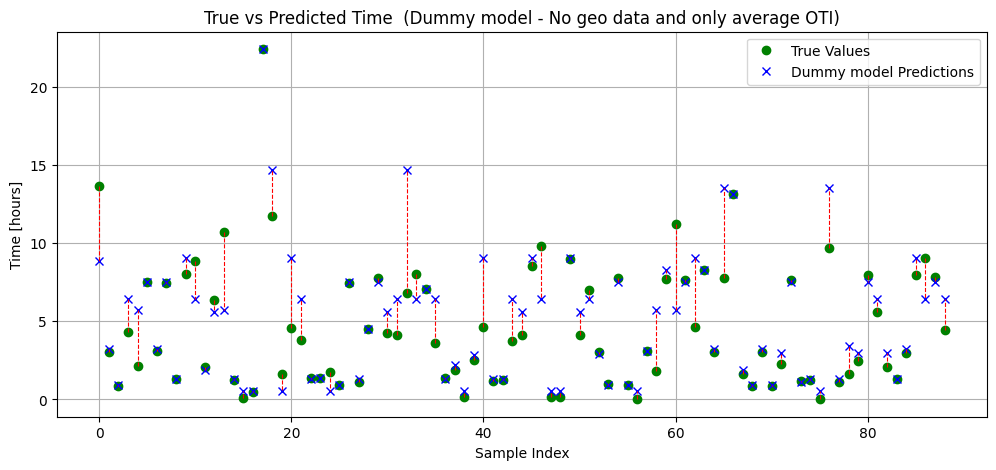

In [1514]:
plot_predictions(y_test, y_pred_dummy, model_name, dataset_name)

##### Linear regression

In [1515]:
model_name: str = LR_MODEL_NAME
models[-1].append(model_name)
lr_model: LinearRegression = train_linear_regression(X_train_norm, y_train, X_val_norm, y_val)

y_pred_lr: np.ndarray = lr_model.predict(X_test_norm)
eval: EvaluationResult = evaluate_model(y_test, y_pred_lr, model_name, dataset_name)
results[-1].append(eval)


Linear Regression Results:
MAE: 1.1642
RMSE: 1.8735
MAPE: 1.0661
MSDP: 0.8241


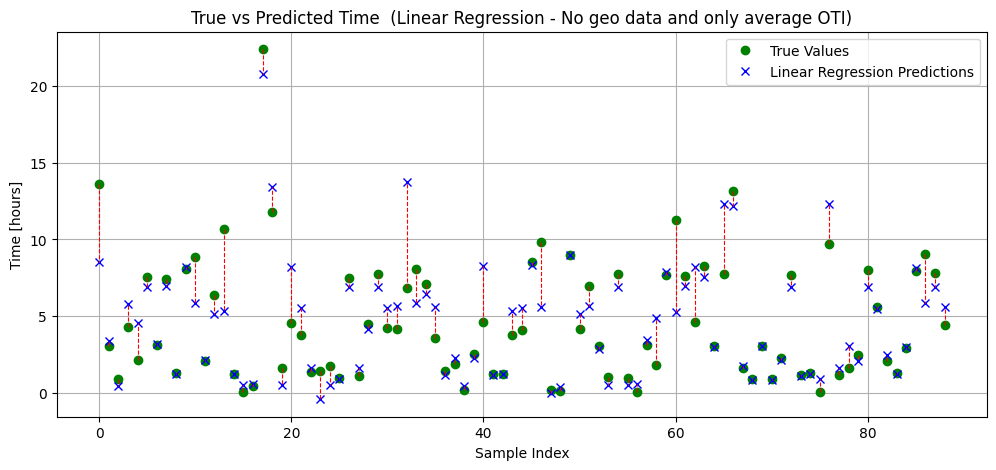

In [1516]:
plot_predictions(y_test, y_pred_lr, model_name, dataset_name)

##### Random Forest

In [1517]:
model_name: str = RFR_MODEL_NAME
models[-1].append(model_name)

rf_model: RandomForestRegressor = train_random_forest(X_train, y_train, X_val, y_val)
rf_model

,n_estimators,100
,criterion,'absolute_error'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,True


In [1518]:
# Predict on the test set
y_pred_rf = rf_model.predict(X_test)

eval: EvaluationResult = evaluate_model(y_test, y_pred_rf, model_name, dataset_name)
results[-1].append(eval)


Random Forest Results:
MAE: 1.0460
RMSE: 1.5908
MAPE: 1.6122
MSDP: 1.5208


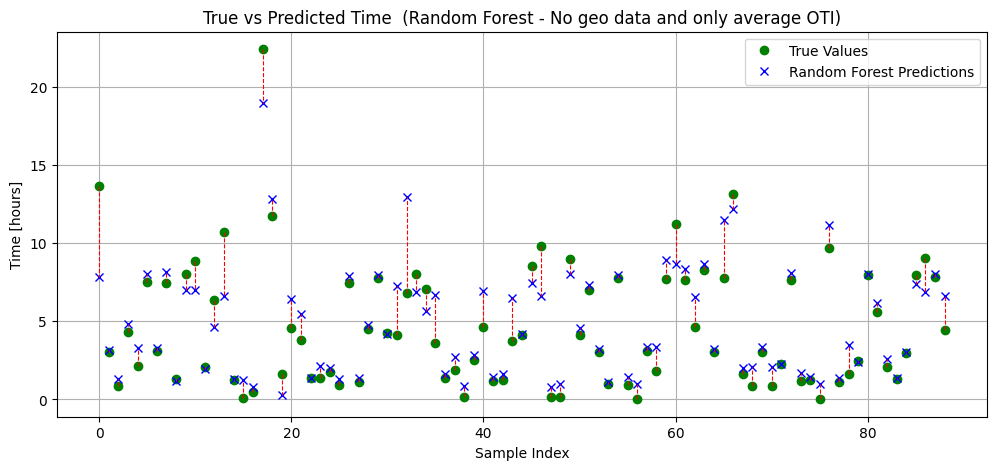

In [1519]:
plot_predictions(y_test, y_pred_rf, model_name, dataset_name)

##### XGBoost

In [1520]:
model_name: str = XGB_MODEL_NAME
models[-1].append(model_name)

xgb_model: Booster = train_xgb(X_train, y_train, X_val, y_val)
xgb_model

[0]	eval-mae:3.50581
[1]	eval-mae:3.42409
[2]	eval-mae:3.15559
[3]	eval-mae:2.91783
[4]	eval-mae:2.70940
[5]	eval-mae:2.64854
[6]	eval-mae:2.46929
[7]	eval-mae:2.46988
[8]	eval-mae:2.34130
[9]	eval-mae:2.19952
[10]	eval-mae:2.08652
[11]	eval-mae:1.96297
[12]	eval-mae:1.93082
[13]	eval-mae:1.81993
[14]	eval-mae:1.74153
[15]	eval-mae:1.74594
[16]	eval-mae:1.68792
[17]	eval-mae:1.69953
[18]	eval-mae:1.68412
[19]	eval-mae:1.62621
[20]	eval-mae:1.57036
[21]	eval-mae:1.52165
[22]	eval-mae:1.48356
[23]	eval-mae:1.43397
[24]	eval-mae:1.39121
[25]	eval-mae:1.35705
[26]	eval-mae:1.34084
[27]	eval-mae:1.34075
[28]	eval-mae:1.31747
[29]	eval-mae:1.32779
[30]	eval-mae:1.30640
[31]	eval-mae:1.28463
[32]	eval-mae:1.27208
[33]	eval-mae:1.25271
[34]	eval-mae:1.24609
[35]	eval-mae:1.22625
[36]	eval-mae:1.24985
[37]	eval-mae:1.24069
[38]	eval-mae:1.24493
[39]	eval-mae:1.24451
[40]	eval-mae:1.23946
[41]	eval-mae:1.22545
[42]	eval-mae:1.23087
[43]	eval-mae:1.22996
[44]	eval-mae:1.21676
[45]	eval-mae:1.2224

In [1521]:
dtest = DMatrix(X_test, label=y_test)

# Predict on the test set
y_pred_xgb = xgb_model.predict(dtest)

eval: EvaluationResult = evaluate_model(y_test, y_pred_xgb, model_name, dataset_name)
results[-1].append(eval)


XGBoost Results:
MAE: 1.1352
RMSE: 2.1715
MAPE: 1.0516
MSDP: 0.6645


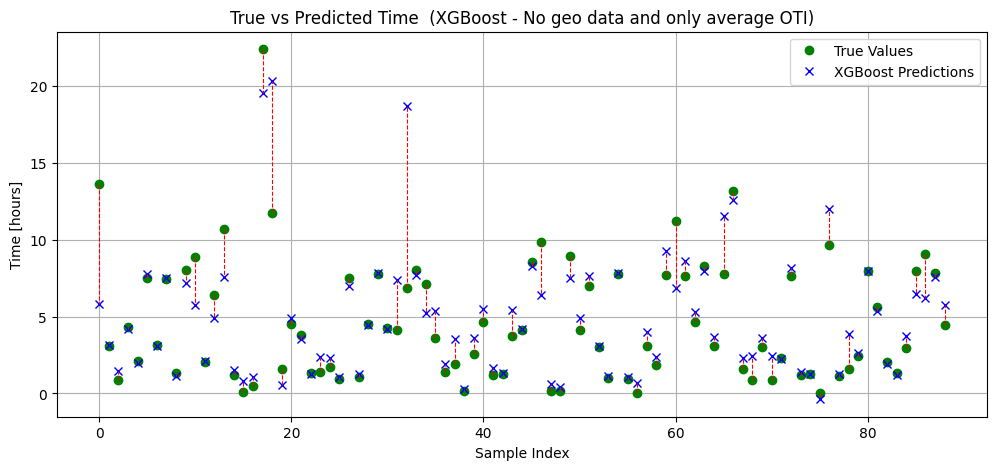

In [1522]:
plot_predictions(y_test, y_pred_xgb, model_name, dataset_name)

##### LightGBM

In [1523]:
model_name: str = GBM_MODEL_NAME
models[-1].append(model_name)

lgb_model: lgb.Booster = train_lgb(X_train, y_train, X_val, y_val)
lgb_model

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[181]	eval's l1: 1.21643


In [1524]:
# Predict on the test set using the best iteration
y_pred_lgb = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)

eval: EvaluationResult = evaluate_model(y_test, y_pred_lgb, model_name, dataset_name)       # type: ignore
results[-1].append(eval)


LightGBM Results:
MAE: 1.1943
RMSE: 1.9036
MAPE: 1.0228
MSDP: 0.8276


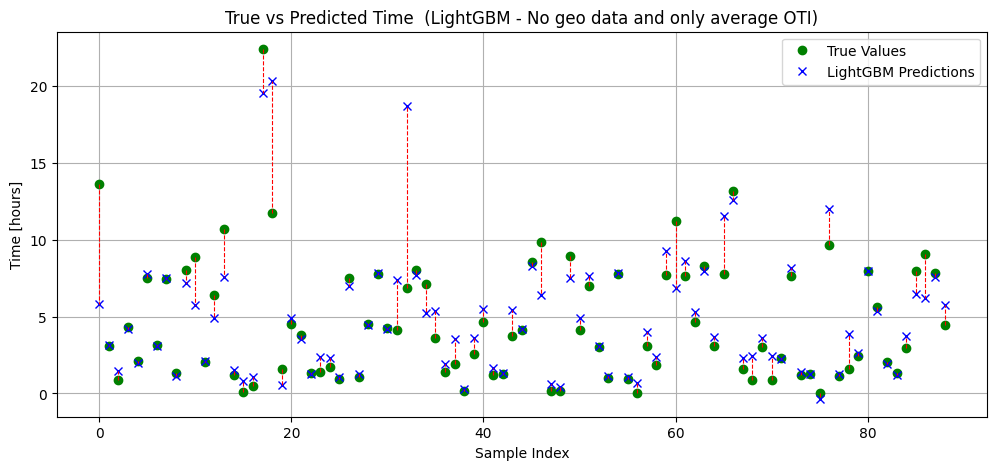

In [1525]:
plot_predictions(y_test, y_pred_xgb, model_name, dataset_name)

##### Comparison

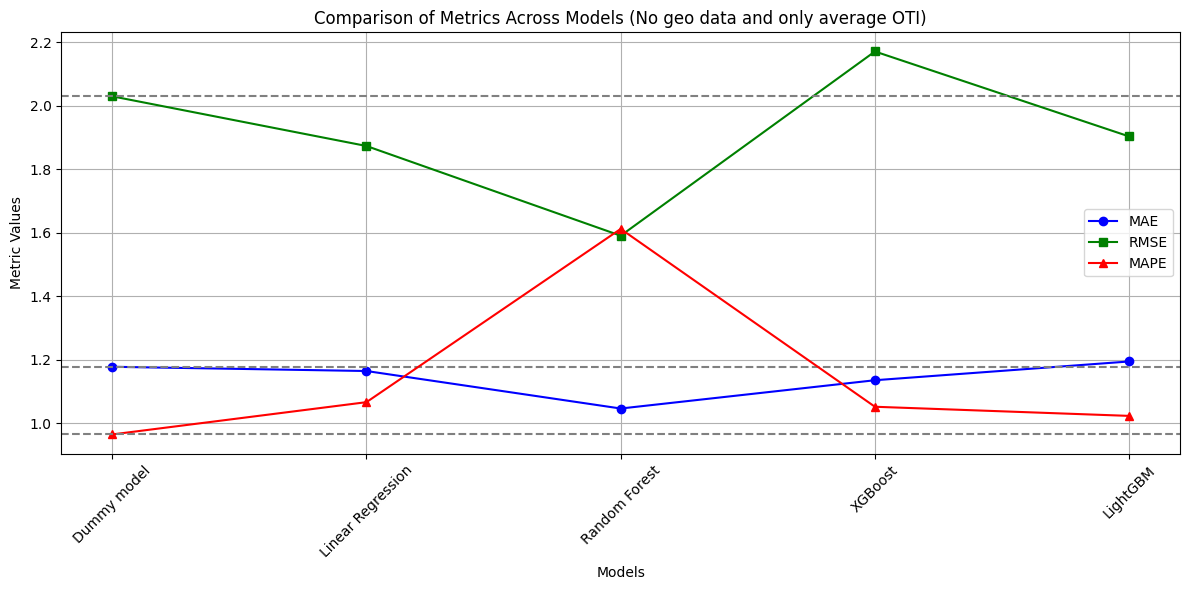

In [1526]:
plot_metrics_comparison(results, models, dataset_name)

#### Geo data and only average time

In [1527]:
dataset_name: str = 'Geo data and only average OTI'
datasets.append(dataset_name)
results.append([])
models.append([])

In [1528]:
X: pd.DataFrame = routes_df.loc[:, ['distance', 'tmi', 'wmi', 'avg_oti', 'time']]
y: pd.Series = X.pop('time')

X.head()

,distance,tmi,wmi,avg_oti
0,61.761066,0.00000,0.224436,3.683333
1,9381.875452,0.00000,0.750000,18.966667
2,564.352543,0.00000,0.101561,1.983333
3,664.754853,0.00000,0.119203,1.860000
4,46.277438,0.14811,0.103400,0.944792


In [1529]:
if AUGMENT_DATA:
    X_augmented: pd.DataFrame = augmented_routes_df.loc[:, ['distance', 'tmi', 'wmi', 'avg_oti', 'time']]
    y_augmented: pd.Series = X_augmented.pop('time')
else:
    X_augmented: pd.DataFrame = pd.DataFrame(columns=X.columns)
    y_augmented: pd.Series = pd.Series(dtype=float)

X_augmented.head()

,distance,tmi,wmi,avg_oti
0,9443.636517,0.000000,0.746563,22.650000
1,9946.227995,0.000000,0.713207,20.950000
2,1229.107397,0.000000,0.111102,3.843333
3,711.032292,0.009640,0.118174,2.804792
4,62.925407,0.170181,0.098869,3.941667


In [1530]:
splits: DataSplit = split_data(X, y)
if AUGMENT_DATA:
    splits = concat_augmented_data(splits, X_augmented, y_augmented)

trainable_splits: TrainableDataSplit = normalize_data(splits, normalize=False)
X_train, X_val, X_test = trainable_splits.X_train, trainable_splits.X_val, trainable_splits.X_test
print(f"X_train shape: {X_train.shape}, X_val shape: {X_val.shape}, X_test shape: {X_test.shape}")

trainable_normalized_splits: TrainableDataSplit = normalize_data(splits, normalize=True)
X_train_norm, X_val_norm, X_test_norm = trainable_normalized_splits.X_train, trainable_normalized_splits.X_val, trainable_normalized_splits.X_test
print(f"X_train_norm shape: {X_train_norm.shape}, X_val_norm shape: {X_val_norm.shape}, X_test_norm shape: {X_test_norm.shape}")

X_train shape: (857, 4), X_val shape: (45, 4), X_test shape: (89, 4)
X_train_norm shape: (857, 4), X_val_norm shape: (45, 4), X_test_norm shape: (89, 4)


In [1531]:
y_train, y_val, y_test = trainable_splits.y_train, trainable_splits.y_val, trainable_splits.y_test
print(f"Train set shape: {y_train.shape}, Val set shape: {y_val.shape}, Test set shape: {y_test.shape}")

Train set shape: (857,), Val set shape: (45,), Test set shape: (89,)


##### Dummy model

In [1532]:
model_name: str = DUMMY_MODEL_NAME
y_pred_dummy: np.ndarray = splits.X_test['avg_oti'].to_numpy()

eval: EvaluationResult = evaluate_model(y_test, y_pred_dummy, model_name, dataset_name)

models[-1].append(model_name)
results[-1].append(eval)


Dummy model Results:
MAE: 1.1776
RMSE: 2.0302
MAPE: 0.9643
MSDP: 0.8628


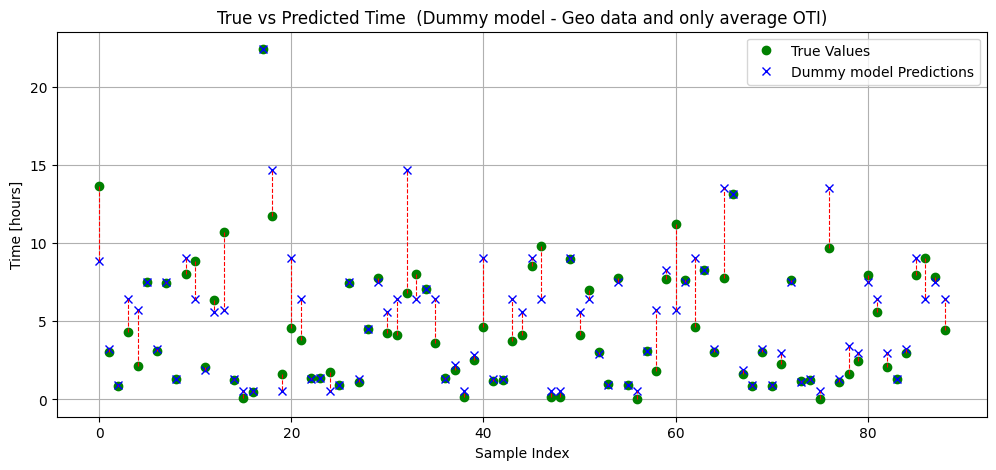

In [1533]:
plot_predictions(y_test, y_pred_dummy, model_name, dataset_name)

##### Linear regression

In [1534]:
model_name: str = LR_MODEL_NAME
models[-1].append(model_name)
lr_model: LinearRegression = train_linear_regression(X_train_norm, y_train, X_val_norm, y_val)

y_pred_lr: np.ndarray = lr_model.predict(X_test_norm)
eval: EvaluationResult = evaluate_model(y_test, y_pred_lr, model_name, dataset_name)
results[-1].append(eval)


Linear Regression Results:
MAE: 1.1421
RMSE: 1.8697
MAPE: 1.0047
MSDP: 0.7772


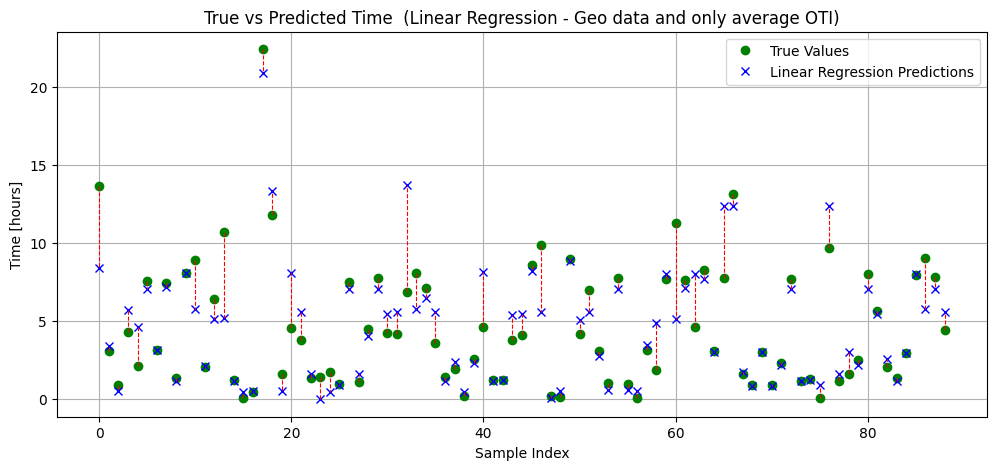

In [1535]:
plot_predictions(y_test, y_pred_lr, model_name, dataset_name)

##### Random Forest

In [1536]:
model_name: str = RFR_MODEL_NAME
models[-1].append(model_name)

rf_model: RandomForestRegressor = train_random_forest(X_train, y_train, X_val, y_val)
rf_model

,n_estimators,100
,criterion,'absolute_error'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,True


In [1537]:
# Predict on the test set
y_pred_rf = rf_model.predict(X_test)

eval: EvaluationResult = evaluate_model(y_test, y_pred_rf, model_name, dataset_name)
results[-1].append(eval)


Random Forest Results:
MAE: 0.9721
RMSE: 1.7480
MAPE: 0.7622
MSDP: 0.6539


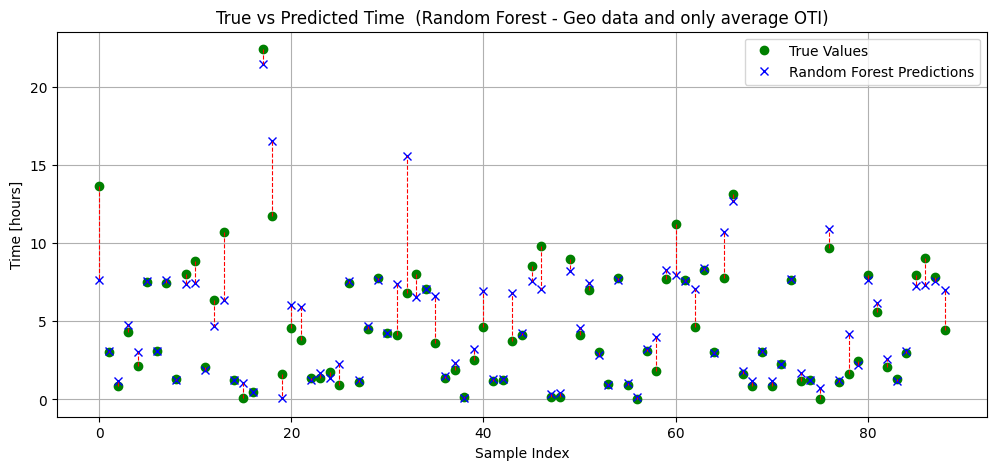

In [1538]:
plot_predictions(y_test, y_pred_rf, model_name, dataset_name)

##### XGBoost

In [1539]:
model_name: str = XGB_MODEL_NAME
models[-1].append(model_name)

xgb_model: Booster = train_xgb(X_train, y_train, X_val, y_val)
xgb_model

[0]	eval-mae:3.51622
[1]	eval-mae:3.23644
[2]	eval-mae:2.97450
[3]	eval-mae:2.73435
[4]	eval-mae:2.51944
[5]	eval-mae:2.31946
[6]	eval-mae:2.17854
[7]	eval-mae:2.05465
[8]	eval-mae:1.93534
[9]	eval-mae:1.83083
[10]	eval-mae:1.74086
[11]	eval-mae:1.65711
[12]	eval-mae:1.55649
[13]	eval-mae:1.49025
[14]	eval-mae:1.39638
[15]	eval-mae:1.31288
[16]	eval-mae:1.26047
[17]	eval-mae:1.21956
[18]	eval-mae:1.17292
[19]	eval-mae:1.14511
[20]	eval-mae:1.12259
[21]	eval-mae:1.11118
[22]	eval-mae:1.08828
[23]	eval-mae:1.07685
[24]	eval-mae:1.06797
[25]	eval-mae:1.06691
[26]	eval-mae:1.04585
[27]	eval-mae:1.04962
[28]	eval-mae:1.04247
[29]	eval-mae:1.03614
[30]	eval-mae:1.02555
[31]	eval-mae:1.02669
[32]	eval-mae:1.00703
[33]	eval-mae:0.99060
[34]	eval-mae:0.99342
[35]	eval-mae:0.99243
[36]	eval-mae:0.99468
[37]	eval-mae:1.00017
[38]	eval-mae:0.99937
[39]	eval-mae:0.99955
[40]	eval-mae:0.99897
[41]	eval-mae:0.99495
[42]	eval-mae:0.99383
[43]	eval-mae:0.99404
[44]	eval-mae:0.99524
[45]	eval-mae:0.9944

In [1540]:
dtest: DMatrix = DMatrix(X_test, label=y_test)

# Predict on the test set
y_pred_xgb: np.ndarray = xgb_model.predict(dtest)

eval: EvaluationResult = evaluate_model(y_test, y_pred_xgb, model_name, dataset_name)
results[-1].append(eval)


XGBoost Results:
MAE: 0.8728
RMSE: 1.8532
MAPE: 0.5783
MSDP: 0.4494


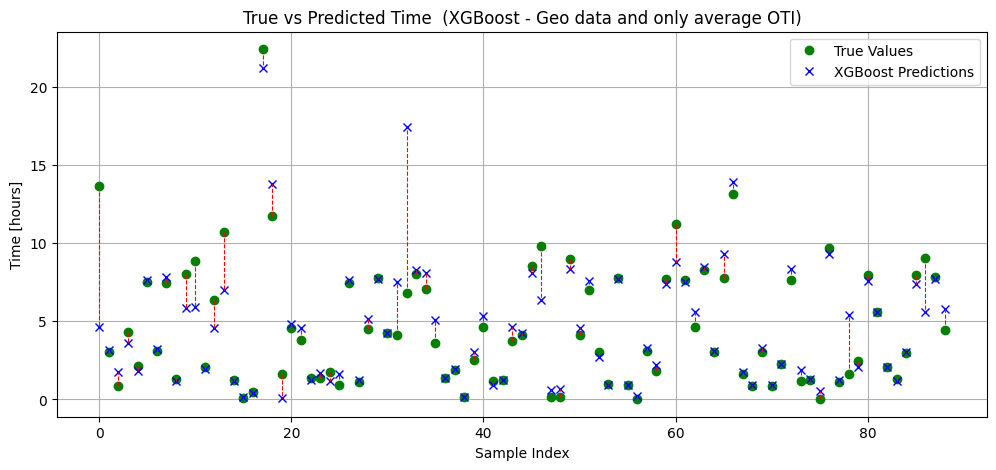

In [1541]:
plot_predictions(y_test, y_pred_xgb, model_name, dataset_name)

##### LightGBM

In [1542]:
model_name: str = GBM_MODEL_NAME
models[-1].append(model_name)

lgb_model: lgb.Booster = train_lgb(X_train, y_train, X_val, y_val)
lgb_model

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[98]	eval's l1: 1.12974


In [1543]:
# Predict on the test set using the best iteration
y_pred_lgb = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)

eval: EvaluationResult = evaluate_model(y_test, y_pred_lgb, model_name, dataset_name)     # type: ignore
results[-1].append(eval)


LightGBM Results:
MAE: 1.0470
RMSE: 1.8543
MAPE: 1.0007
MSDP: 0.7755


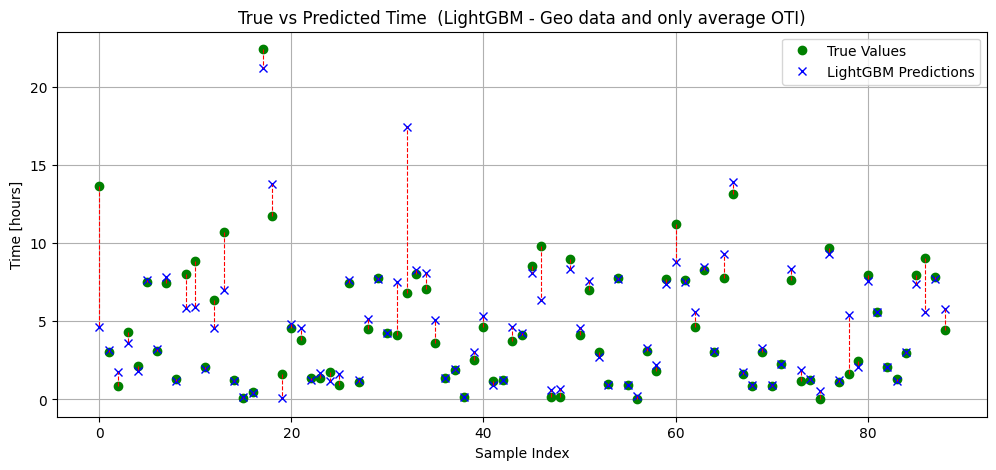

In [1544]:
plot_predictions(y_test, y_pred_xgb, model_name, dataset_name)

##### Comparison

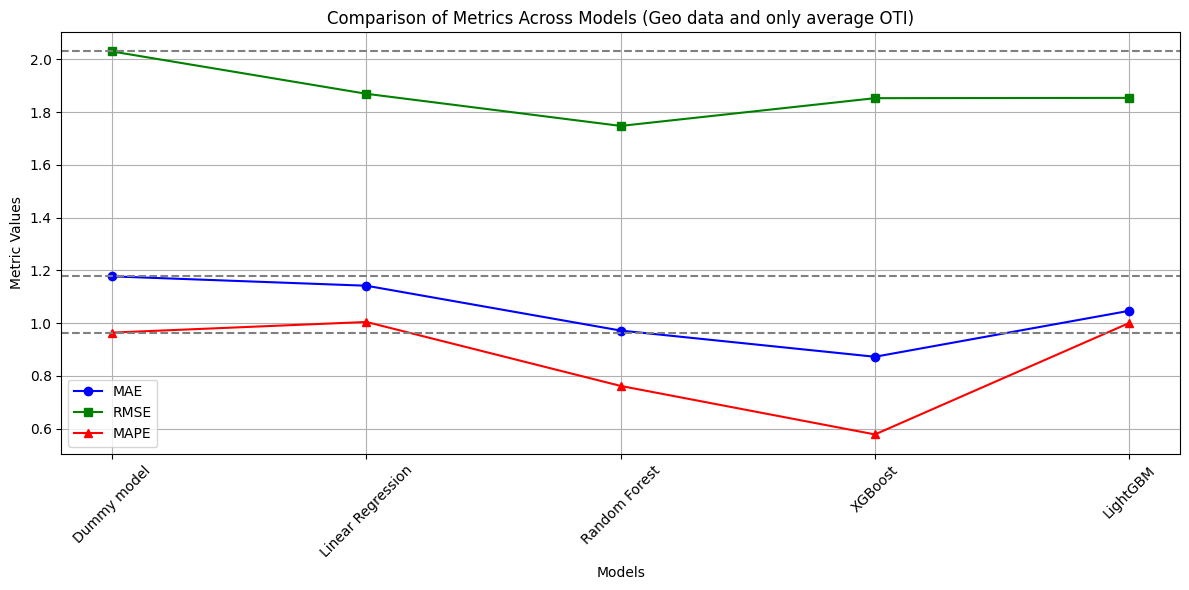

In [1545]:
plot_metrics_comparison(results, models, dataset_name)

#### No geo data and all averages

In [1546]:
dataset_name: str = 'No geo data all averages'
datasets.append(dataset_name)
models.append([])
results.append([])

In [1547]:
X: pd.DataFrame = routes_df.loc[:, ['tmi', 'avg_tmi', 'wmi', 'avg_wmi', 'avg_oti', 'time']]
y: pd.Series = X.pop('time')

X.head()

,tmi,avg_tmi,wmi,avg_wmi,avg_oti
0,0.00000,0.000000,0.224436,0.224436,3.683333
1,0.00000,0.000000,0.750000,0.750000,18.966667
2,0.00000,0.000000,0.101561,0.101561,1.983333
3,0.00000,0.000000,0.119203,0.231342,1.860000
4,0.14811,0.094904,0.103400,0.106983,0.944792


In [1548]:
if AUGMENT_DATA:
    X_augmented: pd.DataFrame = augmented_routes_df.loc[:, ['tmi', 'avg_tmi', 'wmi', 'avg_wmi', 'avg_oti', 'time']]
    y_augmented: pd.Series = X_augmented.pop('time')
else:
    X_augmented: pd.DataFrame = pd.DataFrame(columns=X.columns)
    y_augmented: pd.Series = pd.Series(dtype=float)

X_augmented.head()

,tmi,avg_tmi,wmi,avg_wmi,avg_oti
0,0.000000,0.000000,0.746563,0.746563,22.650000
1,0.000000,0.000000,0.713207,0.713207,20.950000
2,0.000000,0.000000,0.111102,0.171752,3.843333
3,0.009640,0.006177,0.118174,0.223248,2.804792
4,0.170181,0.069796,0.098869,0.078679,3.941667


In [1549]:
splits: DataSplit = split_data(X, y)
if AUGMENT_DATA:
    splits = concat_augmented_data(splits, X_augmented, y_augmented)

trainable_splits: TrainableDataSplit = normalize_data(splits, normalize=False)
X_train, X_val, X_test = trainable_normalized_splits.X_train, trainable_normalized_splits.X_val, trainable_normalized_splits.X_test
print(f"X_train shape: {X_train.shape}, X_val shape: {X_val.shape}, X_test shape: {X_test.shape}")

trainable_normalized_splits: TrainableDataSplit = normalize_data(splits, normalize=True)
X_train_norm, X_val_norm, X_test_norm = trainable_normalized_splits.X_train, trainable_normalized_splits.X_val, trainable_normalized_splits.X_test
print(f"X_train_norm shape: {X_train_norm.shape}, X_val_norm shape: {X_val_norm.shape}, X_test_norm shape: {X_test_norm.shape}")

X_train shape: (857, 4), X_val shape: (45, 4), X_test shape: (89, 4)
X_train_norm shape: (857, 5), X_val_norm shape: (45, 5), X_test_norm shape: (89, 5)


In [1550]:
y_train, y_val, y_test = trainable_normalized_splits.y_train, trainable_normalized_splits.y_val, trainable_normalized_splits.y_test
print(f"Train set shape: {y_train.shape}, Val set shape: {y_val.shape}, Test set shape: {y_test.shape}")

Train set shape: (857,), Val set shape: (45,), Test set shape: (89,)


##### Dummy model

In [1551]:
model_name: str = DUMMY_MODEL_NAME
y_pred_dummy: np.ndarray = splits.X_test['avg_oti'].to_numpy()

eval: EvaluationResult = evaluate_model(y_test, y_pred_dummy, model_name, dataset_name)

models[-1].append(model_name)
results[-1].append(eval)


Dummy model Results:
MAE: 1.1776
RMSE: 2.0302
MAPE: 0.9643
MSDP: 0.8628


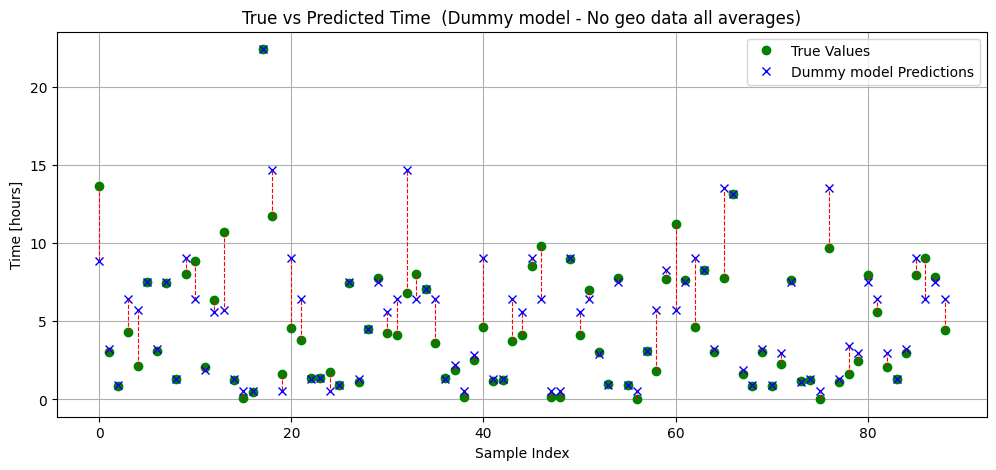

In [1552]:
plot_predictions(y_test, y_pred_dummy, model_name, dataset_name)

##### Linear regression

In [1553]:
model_name: str = LR_MODEL_NAME
models[-1].append(model_name)
lr_model: LinearRegression = train_linear_regression(X_train_norm, y_train, X_val_norm, y_val)

y_pred_lr: np.ndarray = lr_model.predict(X_test_norm)
eval: EvaluationResult = evaluate_model(y_test, y_pred_lr, model_name, dataset_name)
results[-1].append(eval)


Linear Regression Results:
MAE: 1.3009
RMSE: 1.9193
MAPE: 1.6189
MSDP: 1.1859


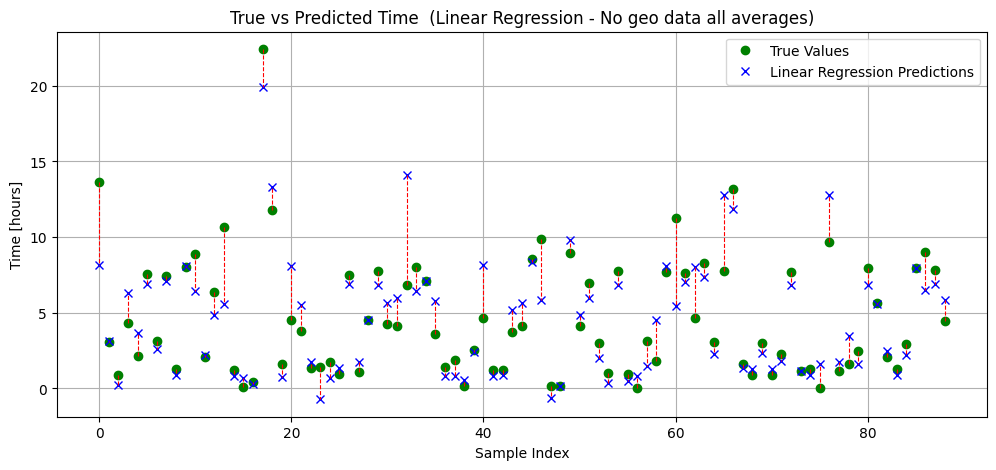

In [1554]:
plot_predictions(y_test, y_pred_lr, model_name, dataset_name)

##### Random Forest

In [1555]:
model_name: str = RFR_MODEL_NAME
models[-1].append(model_name)

rf_model: RandomForestRegressor = train_random_forest(X_train, y_train, X_val, y_val)
rf_model

,n_estimators,100
,criterion,'absolute_error'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,True


In [1556]:
# Predict on the test set
y_pred_rf = rf_model.predict(X_test)

eval: EvaluationResult = evaluate_model(y_test, y_pred_rf, model_name, dataset_name)
results[-1].append(eval)


Random Forest Results:
MAE: 0.9721
RMSE: 1.7480
MAPE: 0.7622
MSDP: 0.6539


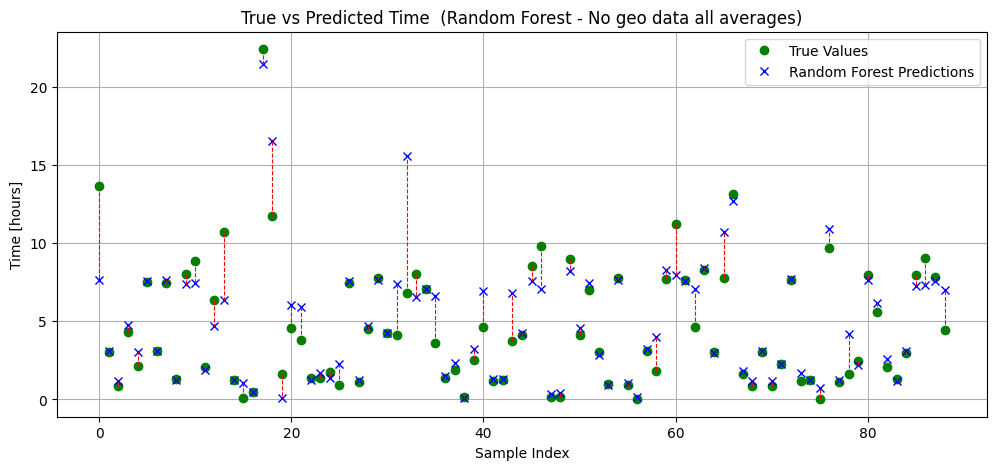

In [1557]:
plot_predictions(y_test, y_pred_rf, model_name, dataset_name)

##### XGBoost

In [1558]:
model_name: str = XGB_MODEL_NAME
models[-1].append(model_name)

xgb_model: Booster = train_xgb(X_train, y_train, X_val, y_val)
xgb_model

[0]	eval-mae:3.51622
[1]	eval-mae:3.23644
[2]	eval-mae:2.97450
[3]	eval-mae:2.73435
[4]	eval-mae:2.51944
[5]	eval-mae:2.31946
[6]	eval-mae:2.17854
[7]	eval-mae:2.05465
[8]	eval-mae:1.93534
[9]	eval-mae:1.83083
[10]	eval-mae:1.74086
[11]	eval-mae:1.65711
[12]	eval-mae:1.55649
[13]	eval-mae:1.49025
[14]	eval-mae:1.39638
[15]	eval-mae:1.31288
[16]	eval-mae:1.26047
[17]	eval-mae:1.21956
[18]	eval-mae:1.17292
[19]	eval-mae:1.14511
[20]	eval-mae:1.12259
[21]	eval-mae:1.11118
[22]	eval-mae:1.08828
[23]	eval-mae:1.07685
[24]	eval-mae:1.06797
[25]	eval-mae:1.06691
[26]	eval-mae:1.04585
[27]	eval-mae:1.04962
[28]	eval-mae:1.04247
[29]	eval-mae:1.03614
[30]	eval-mae:1.02555
[31]	eval-mae:1.02669
[32]	eval-mae:1.00703
[33]	eval-mae:0.99060
[34]	eval-mae:0.99342
[35]	eval-mae:0.99243
[36]	eval-mae:0.99468
[37]	eval-mae:1.00017
[38]	eval-mae:0.99937
[39]	eval-mae:0.99955
[40]	eval-mae:0.99897
[41]	eval-mae:0.99495
[42]	eval-mae:0.99383
[43]	eval-mae:0.99404
[44]	eval-mae:0.99524
[45]	eval-mae:0.9944

In [1559]:
dtest = DMatrix(X_test, label=y_test)

# Predict on the test set
y_pred_xgb = xgb_model.predict(dtest)

eval: EvaluationResult = evaluate_model(y_test, y_pred_xgb, model_name, dataset_name)
results[-1].append(eval)


XGBoost Results:
MAE: 0.8728
RMSE: 1.8532
MAPE: 0.5783
MSDP: 0.4494


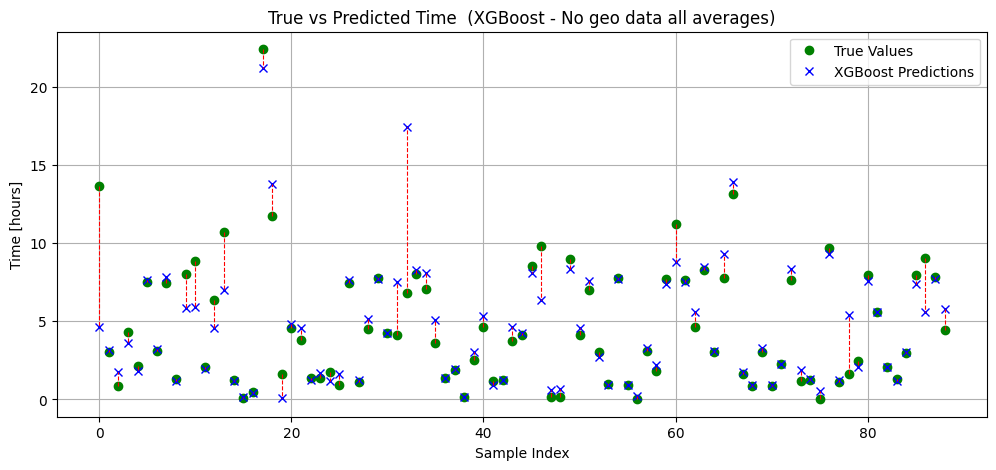

In [1560]:
plot_predictions(y_test, y_pred_xgb, model_name, dataset_name)

##### LightGBM

In [1561]:
model_name: str = GBM_MODEL_NAME
models[-1].append(model_name)

lgb_model: lgb.Booster = train_lgb(X_train, y_train, X_val, y_val)
lgb_model

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[98]	eval's l1: 1.12974


In [1562]:
# Predict on the test set using the best iteration
y_pred_lgb = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)

eval: EvaluationResult = evaluate_model(y_test, y_pred_lgb, model_name, dataset_name)       # type: ignore
results[-1].append(eval)


LightGBM Results:
MAE: 1.0470
RMSE: 1.8543
MAPE: 1.0007
MSDP: 0.7755


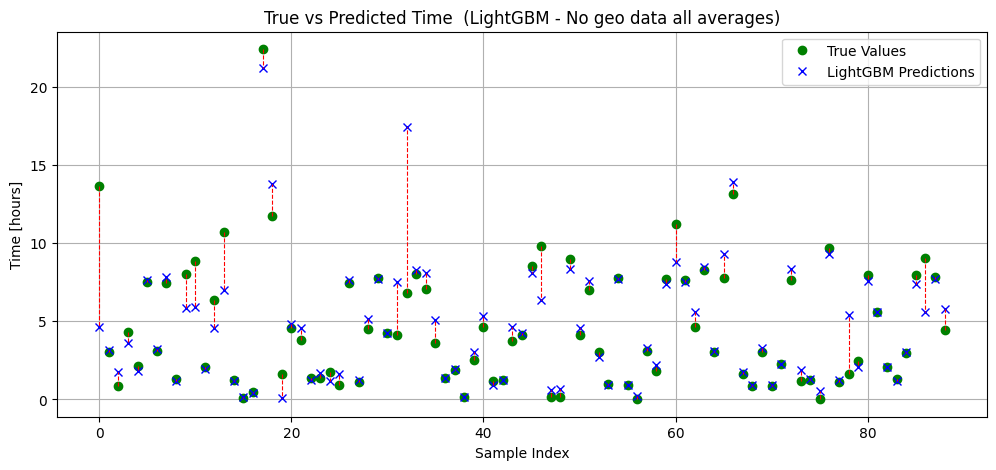

In [1563]:
plot_predictions(y_test, y_pred_xgb, model_name, dataset_name)

##### Comparison

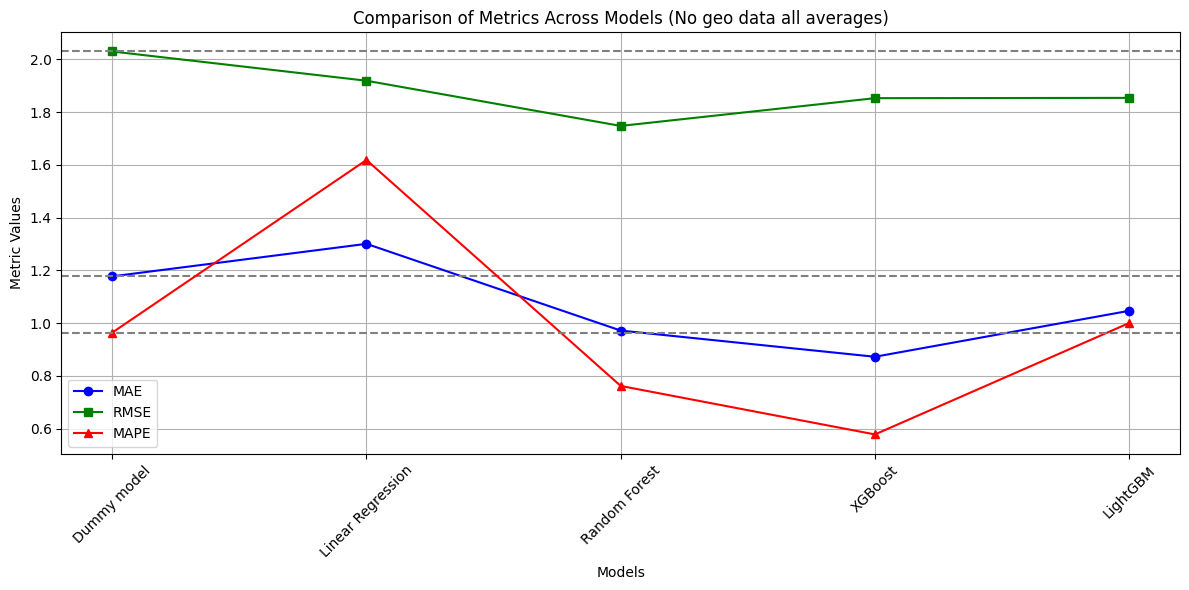

In [1564]:
plot_metrics_comparison(results, models, dataset_name)

#### Geo data and all averages

In [1565]:
dataset_name: str = 'Geo data and all averages'
datasets.append(dataset_name)
models.append([])
results.append([])

In [1566]:
X = routes_df.loc[:, ['distance', 'tmi', 'avg_tmi', 'wmi', 'avg_wmi', 'avg_oti', 'time']]
y = X.pop('time')

X.head()

,distance,tmi,avg_tmi,wmi,avg_wmi,avg_oti
0,61.761066,0.00000,0.000000,0.224436,0.224436,3.683333
1,9381.875452,0.00000,0.000000,0.750000,0.750000,18.966667
2,564.352543,0.00000,0.000000,0.101561,0.101561,1.983333
3,664.754853,0.00000,0.000000,0.119203,0.231342,1.860000
4,46.277438,0.14811,0.094904,0.103400,0.106983,0.944792


In [1567]:
if AUGMENT_DATA:
    X_augmented: pd.DataFrame = augmented_routes_df.loc[:, ['distance', 'tmi', 'avg_tmi', 'wmi', 'avg_wmi', 'avg_oti', 'time']]
    y_augmented: pd.Series = X_augmented.pop('time')
else:
    X_augmented: pd.DataFrame = pd.DataFrame(columns=X.columns)
    y_augmented: pd.Series = pd.Series(dtype=float)

X_augmented.head()

,distance,tmi,avg_tmi,wmi,avg_wmi,avg_oti
0,9443.636517,0.000000,0.000000,0.746563,0.746563,22.650000
1,9946.227995,0.000000,0.000000,0.713207,0.713207,20.950000
2,1229.107397,0.000000,0.000000,0.111102,0.171752,3.843333
3,711.032292,0.009640,0.006177,0.118174,0.223248,2.804792
4,62.925407,0.170181,0.069796,0.098869,0.078679,3.941667


In [1568]:
splits: DataSplit = split_data(X, y)
if AUGMENT_DATA:
    splits = concat_augmented_data(splits, X_augmented, y_augmented)

trainable_splits: TrainableDataSplit = normalize_data(splits, normalize=False)
X_train, X_val, X_test = trainable_splits.X_train, trainable_splits.X_val, trainable_splits.X_test
print(f"X_train shape: {X_train.shape}, X_val shape: {X_val.shape}, X_test shape: {X_test.shape}")

trainable_normalized_splits: TrainableDataSplit = normalize_data(splits, normalize=True)
X_train_norm, X_val_norm, X_test_norm = trainable_normalized_splits.X_train, trainable_normalized_splits.X_val, trainable_normalized_splits.X_test
print(f"X_train_norm shape: {X_train_norm.shape}, X_val_norm shape: {X_val_norm.shape}, X_test_norm shape: {X_test_norm.shape}")

X_train shape: (857, 6), X_val shape: (45, 6), X_test shape: (89, 6)
X_train_norm shape: (857, 6), X_val_norm shape: (45, 6), X_test_norm shape: (89, 6)


In [1569]:
y_train, y_val, y_test = trainable_normalized_splits.y_train, trainable_normalized_splits.y_val, trainable_normalized_splits.y_test
print(f"Train set shape: {y_train.shape}, Val set shape: {y_val.shape}, Test set shape: {y_test.shape}")

Train set shape: (857,), Val set shape: (45,), Test set shape: (89,)


##### Dummy model

In [1570]:
model_name: str = DUMMY_MODEL_NAME
y_pred_dummy: np.ndarray = splits.X_test['avg_oti'].to_numpy()

eval: EvaluationResult = evaluate_model(y_test, y_pred_dummy, model_name, dataset_name)

models[-1].append(model_name)
results[-1].append(eval)


Dummy model Results:
MAE: 1.1776
RMSE: 2.0302
MAPE: 0.9643
MSDP: 0.8628


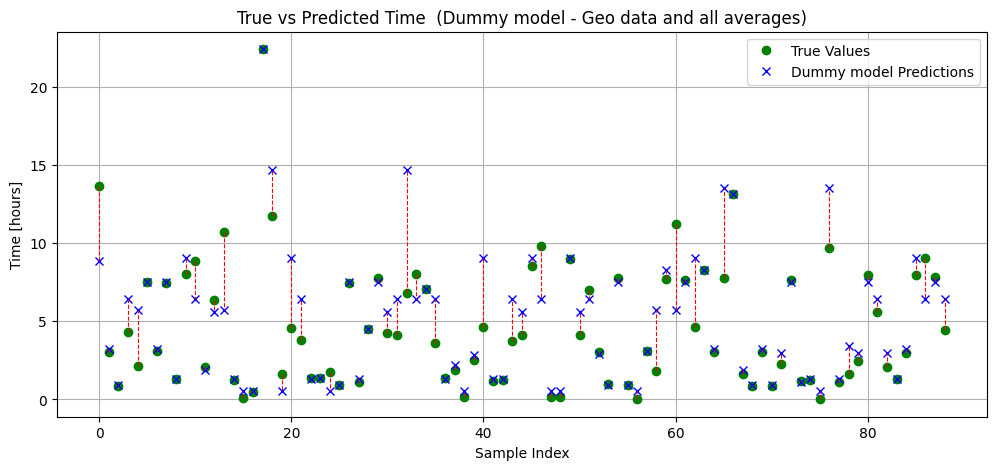

In [1571]:
plot_predictions(y_test, y_pred_dummy, model_name, dataset_name)

##### Linear regression

In [1572]:
model_name: str = LR_MODEL_NAME
models[-1].append(model_name)
lr_model: LinearRegression = train_linear_regression(X_train_norm, y_train, X_val_norm, y_val)

y_pred_lr: np.ndarray = lr_model.predict(X_test_norm)
eval: EvaluationResult = evaluate_model(y_test, y_pred_lr, model_name, dataset_name)
results[-1].append(eval)


Linear Regression Results:
MAE: 1.2794
RMSE: 1.9078
MAPE: 1.5687
MSDP: 1.1534


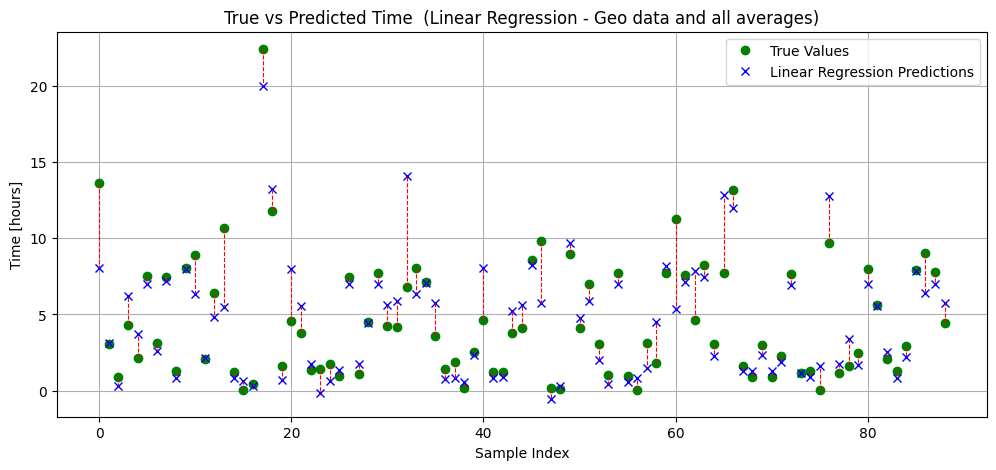

In [1573]:
plot_predictions(y_test, y_pred_lr, model_name, dataset_name)

##### Random Forest

In [1574]:
model_name: str = RFR_MODEL_NAME
models[-1].append(model_name)

rf_model: RandomForestRegressor = train_random_forest(X_train, y_train, X_val, y_val)
rf_model

,n_estimators,100
,criterion,'absolute_error'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,True


In [1575]:
# Predict on the test set
y_pred_rf = rf_model.predict(X_test)

eval: EvaluationResult = evaluate_model(y_test, y_pred_rf, model_name, dataset_name)
results[-1].append(eval)


Random Forest Results:
MAE: 0.9769
RMSE: 1.7223
MAPE: 0.7675
MSDP: 0.6624


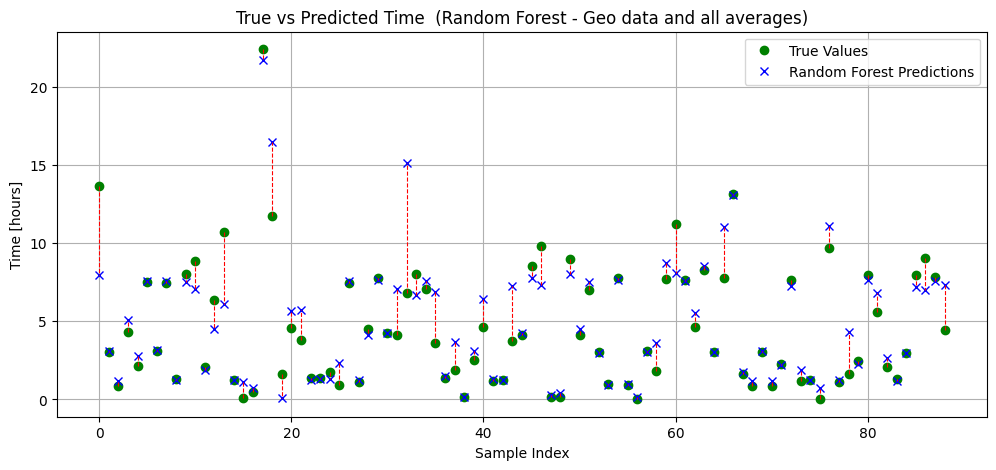

In [1576]:
plot_predictions(y_test, y_pred_rf, model_name, dataset_name)

##### XGBoost

In [1577]:
model_name: str = XGB_MODEL_NAME
models[-1].append(model_name)

xgb_model: Booster = train_xgb(X_train, y_train, X_val, y_val)
xgb_model

[0]	eval-mae:3.53578
[1]	eval-mae:3.20740
[2]	eval-mae:2.93914
[3]	eval-mae:2.68753
[4]	eval-mae:2.48458
[5]	eval-mae:2.30428
[6]	eval-mae:2.11982
[7]	eval-mae:1.97168
[8]	eval-mae:1.86123
[9]	eval-mae:1.71315
[10]	eval-mae:1.60230
[11]	eval-mae:1.51318
[12]	eval-mae:1.44502
[13]	eval-mae:1.38115
[14]	eval-mae:1.33634
[15]	eval-mae:1.27694
[16]	eval-mae:1.23996
[17]	eval-mae:1.19271
[18]	eval-mae:1.16292
[19]	eval-mae:1.14164
[20]	eval-mae:1.11857
[21]	eval-mae:1.09689
[22]	eval-mae:1.07638
[23]	eval-mae:1.07819
[24]	eval-mae:1.06290
[25]	eval-mae:1.05034
[26]	eval-mae:1.03707
[27]	eval-mae:1.02770
[28]	eval-mae:1.01838
[29]	eval-mae:1.01167
[30]	eval-mae:1.00462
[31]	eval-mae:0.99601
[32]	eval-mae:0.99121
[33]	eval-mae:0.98696
[34]	eval-mae:0.98600
[35]	eval-mae:0.98009
[36]	eval-mae:0.97794
[37]	eval-mae:0.97640
[38]	eval-mae:0.97397
[39]	eval-mae:0.97424
[40]	eval-mae:0.97305
[41]	eval-mae:0.97306
[42]	eval-mae:0.97141
[43]	eval-mae:0.97067
[44]	eval-mae:0.97351
[45]	eval-mae:0.9744

In [1578]:
dtest = DMatrix(X_test, label=y_test)

# Predict on the test set
y_pred_xgb = xgb_model.predict(dtest)

eval: EvaluationResult = evaluate_model(y_test, y_pred_xgb, model_name, dataset_name)
results[-1].append(eval)


XGBoost Results:
MAE: 0.8464
RMSE: 1.5737
MAPE: 0.3793
MSDP: 0.1170


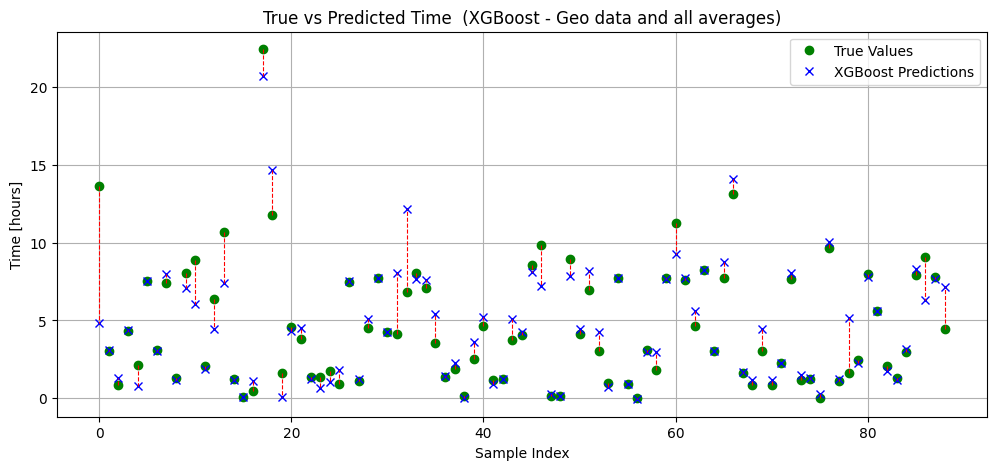

In [1579]:
plot_predictions(y_test, y_pred_xgb, model_name, dataset_name)

##### LightGBM

In [1580]:
model_name: str = GBM_MODEL_NAME
models[-1].append(model_name)

lgb_model: lgb.Booster = train_lgb(X_train, y_train, X_val, y_val)
lgb_model

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[95]	eval's l1: 1.10788


In [1581]:
# Predict on the test set using the best iteration
y_pred_lgb = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)

eval: EvaluationResult = evaluate_model(y_test, y_pred_lgb, model_name, dataset_name)       # type: ignore
results[-1].append(eval)


LightGBM Results:
MAE: 1.0447
RMSE: 1.9264
MAPE: 0.7371
MSDP: 0.4339


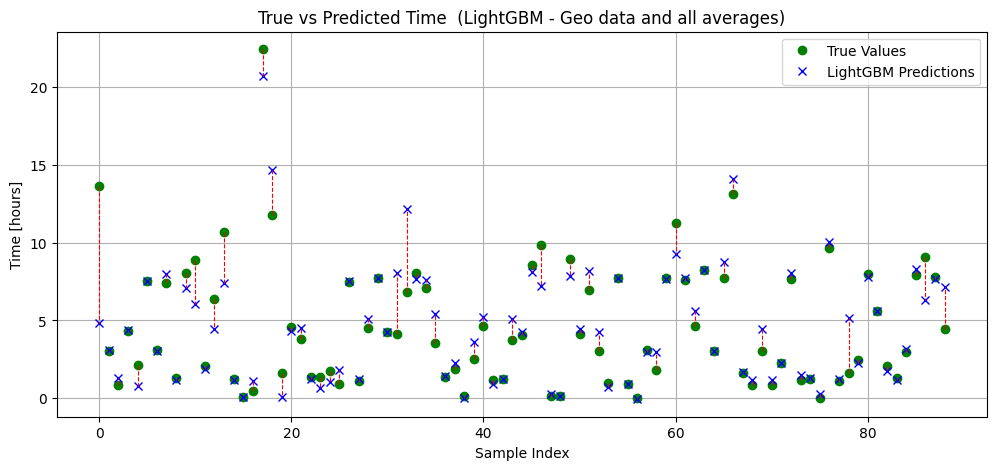

In [1582]:
plot_predictions(y_test, y_pred_xgb, model_name, dataset_name)

##### Comparison

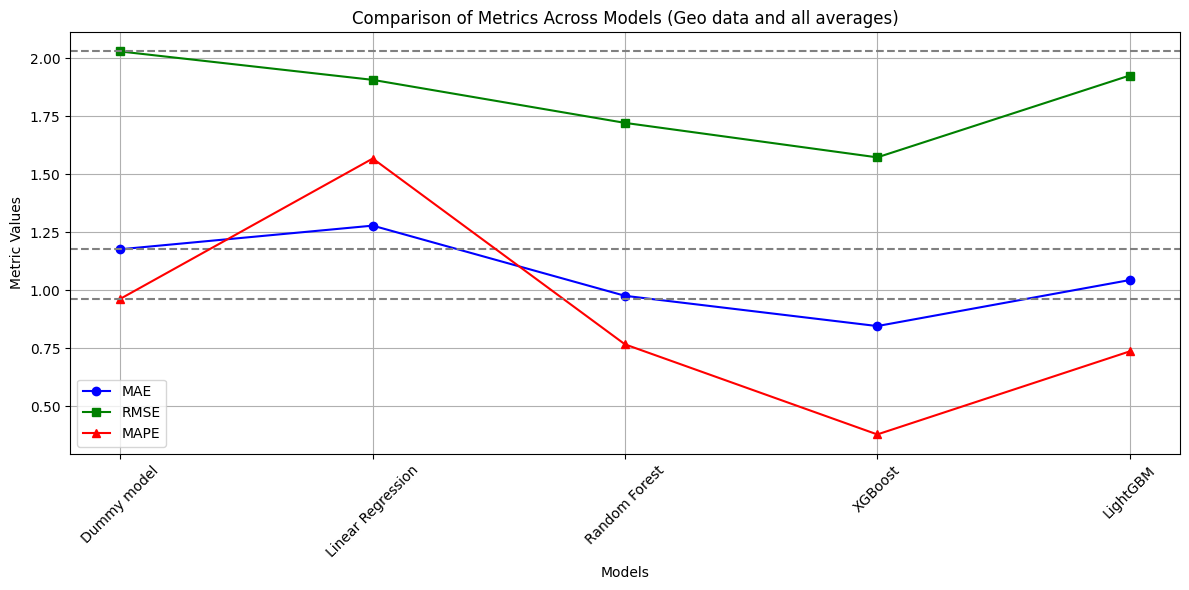

In [1583]:
plot_metrics_comparison(results, models, dataset_name)

#### Comparison

In [1584]:
def plot_model_metrics_across_datasets(results: List[List['EvaluationResult']], 
                                       datasets: List[str], 
                                       model: str,metrics: Tuple[str, str, str],
                                       index: int
                                       ) -> None:

    # Extract metrics
    eval_metrics: List[EvaluationResult] = [evals[index] for evals in results]
    mae: List[float] = [eval.mae for eval in eval_metrics]
    rmse: List[float] = [eval.rmse for eval in eval_metrics]
    mape: List[float] = [eval.mape for eval in eval_metrics]

    x_labels: Tuple[str, str, str] = metrics
    x = np.arange(len(x_labels))
    bar_width: float = 0.2

    plt.figure(figsize=(10, 5))

    for i, dataset_name in enumerate(datasets):
        values = [mae[i], rmse[i], mape[i]]
        bars = plt.bar(x + i * bar_width, values, width=bar_width, label=dataset_name, edgecolor='black')
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom')

    plt.xlabel('Metrics')
    plt.ylabel('Metric Values')
    plt.title(f"{model} Metrics Comparison Across Datasets")
    plt.xticks(x + bar_width * (len(datasets) - 1) / 2, x_labels)
    plt.legend()
    plt.grid(axis='y')
    plt.tight_layout()
    plt.savefig(os.path.join(PLOT_PATH, f"{model}_metrics_across_datasets.png"))
    plt.show()

##### Linear regression

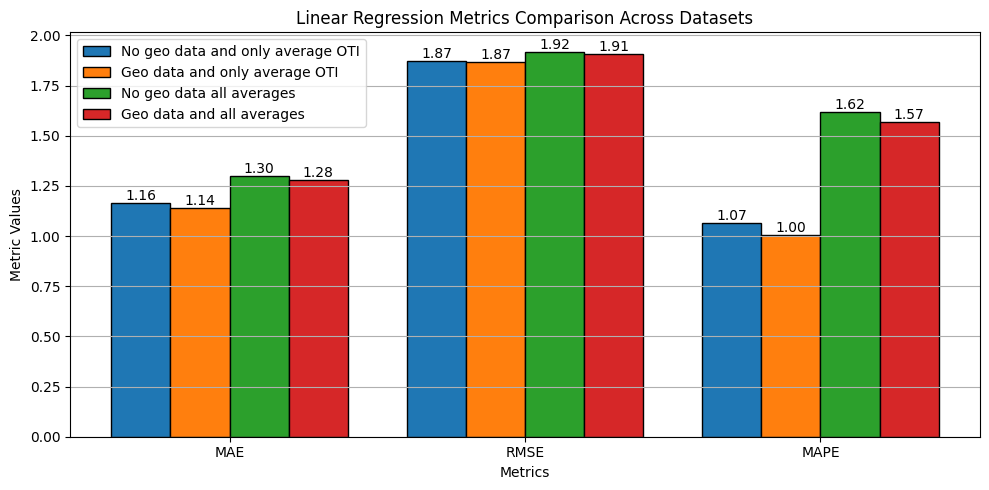

In [1585]:
plot_model_metrics_across_datasets(results, datasets, LR_MODEL_NAME, metrics, 1)

##### Random Forest

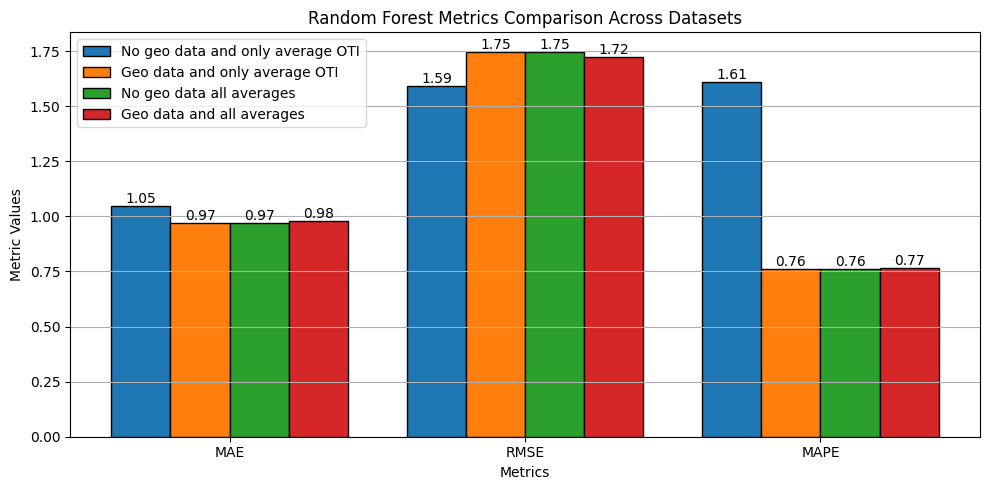

In [1586]:
plot_model_metrics_across_datasets(results, datasets, RFR_MODEL_NAME, metrics, 2)

##### XGBoost

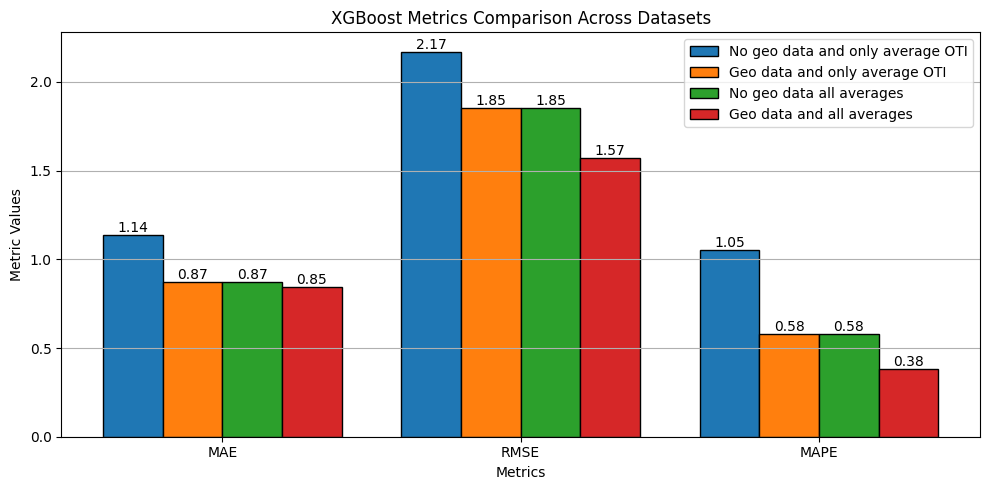

In [1587]:
plot_model_metrics_across_datasets(results, datasets, XGB_MODEL_NAME, metrics, 3)

##### LightGBM

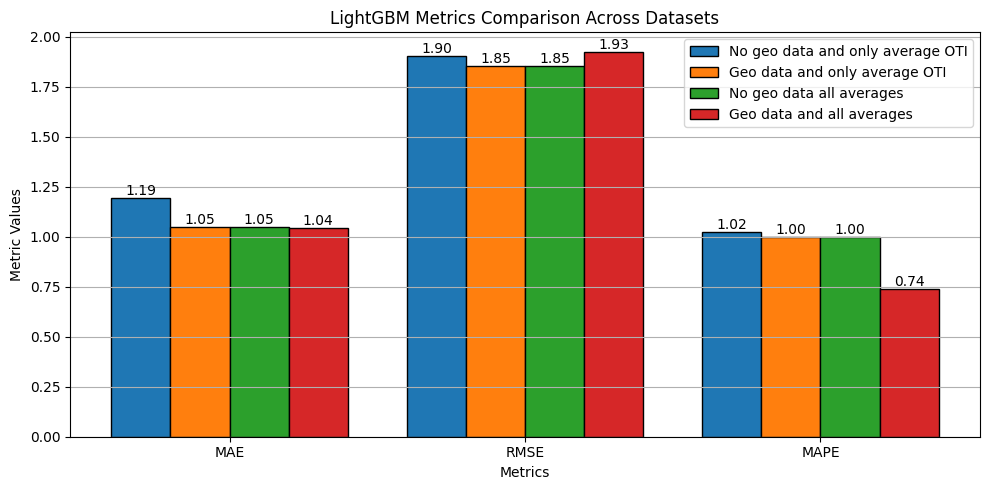

In [1588]:
plot_model_metrics_across_datasets(results, datasets, GBM_MODEL_NAME, metrics, 4)

#### Models evaluation

In [1589]:
metrics

('MAE', 'RMSE', 'MAPE')

##### MAE

In [1590]:
METRIC_NAME: str = 'MAE'

In [1591]:
results_flatten = np.array([[eval.mae for eval in m] for m in results]).flatten()
ranking = np.argsort(results_flatten)

ranked_datasets_indexes = ranking // len(models[0])
ranked_models_indexes = ranking % len(models[0])

ranked_models = [f'{models[dataset_index][model_index]} - {datasets[dataset_index]}' for dataset_index, model_index in zip(ranked_datasets_indexes, ranked_models_indexes)]

print(f'Ranking of models based on {METRIC_NAME}:')
for i, model in enumerate(ranked_models):
    print(f'\t{model}: {results_flatten[ranking][i]}')

Ranking of models based on MAE:
	XGBoost - Geo data and all averages: 0.8464230239963375
	XGBoost - No geo data all averages: 0.8727704507413874
	XGBoost - Geo data and only average OTI: 0.8727704507413874
	Random Forest - Geo data and only average OTI: 0.9720580524344568
	Random Forest - No geo data all averages: 0.9720580524344568
	Random Forest - Geo data and all averages: 0.9768614232209734
	LightGBM - Geo data and all averages: 1.044677459622334
	Random Forest - No geo data and only average OTI: 1.0460271535580525
	LightGBM - No geo data all averages: 1.0469841760510334
	LightGBM - Geo data and only average OTI: 1.0469841760510334
	XGBoost - No geo data and only average OTI: 1.1351819356059312
	Linear Regression - Geo data and only average OTI: 1.1420689597213955
	Linear Regression - No geo data and only average OTI: 1.1642270035197264
	Dummy model - Geo data and all averages: 1.1776020893120611
	Dummy model - No geo data and only average OTI: 1.1776020893120611
	Dummy model - Geo

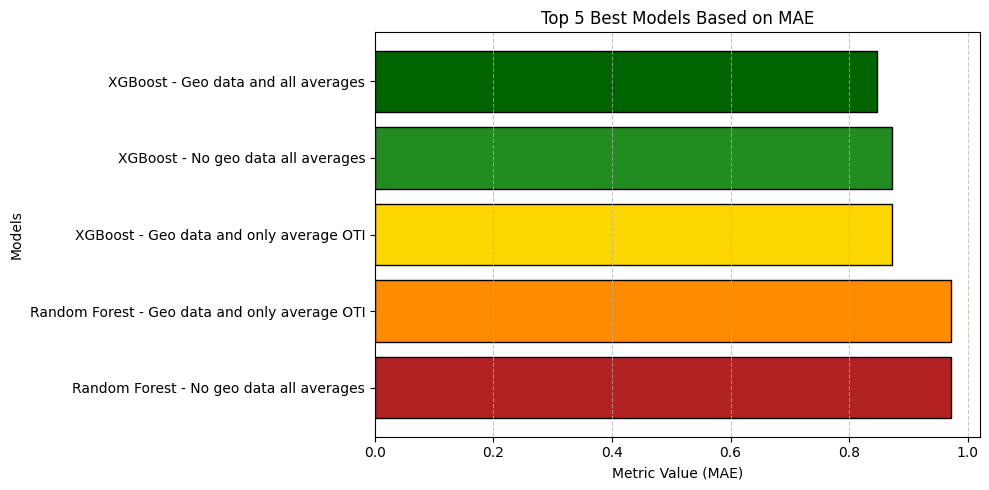

In [1592]:
K: int = 5

best_results = results_flatten[ranking][:K]
best_models = ranked_models[:K]

colors = ['#006400', '#228B22', '#FFD700', '#FF8C00', '#B22222']

plt.figure(figsize=(10, 5))

plt.barh(best_models, best_results, color=colors, edgecolor='black', linewidth=1)
plt.xlabel(f'Metric Value ({METRIC_NAME})')
plt.ylabel('Models')
plt.title(f'Top {K} Best Models Based on {METRIC_NAME}')
plt.gca().invert_yaxis()                                            # Invert y-axis to show the best model at the top
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(os.path.join(PLOT_PATH, f'top_{K}_models_based_on_{METRIC_NAME}.png'))
plt.show()

##### RMSE

In [1593]:
METRIC_NAME: str = 'RMSE'

In [1594]:
results_flatten = np.array([[eval.rmse for eval in m] for m in results]).flatten()
ranking = np.argsort(results_flatten)

ranked_datasets_indexes = ranking // len(models[0])
ranked_models_indexes = ranking % len(models[0])

ranked_models = [f'{models[dataset_index][model_index]} - {datasets[dataset_index]}' for dataset_index, model_index in zip(ranked_datasets_indexes, ranked_models_indexes)]

print(f'Ranking of models based on {METRIC_NAME}:')
for i, model in enumerate(ranked_models):
    print(f'\t{model}: {results_flatten[ranking][i]}')

Ranking of models based on RMSE:
	XGBoost - Geo data and all averages: 1.5737139609684792
	Random Forest - No geo data and only average OTI: 1.59077244281186
	Random Forest - Geo data and all averages: 1.7223238428448089
	Random Forest - No geo data all averages: 1.7479705369288363
	Random Forest - Geo data and only average OTI: 1.7479705369288365
	XGBoost - Geo data and only average OTI: 1.8531504274145294
	XGBoost - No geo data all averages: 1.8531504274145294
	LightGBM - Geo data and only average OTI: 1.8542627132070897
	LightGBM - No geo data all averages: 1.8542627132070897
	Linear Regression - Geo data and only average OTI: 1.8696913979759007
	Linear Regression - No geo data and only average OTI: 1.8735090713344185
	LightGBM - No geo data and only average OTI: 1.9036297486985994
	Linear Regression - Geo data and all averages: 1.9077908078510792
	Linear Regression - No geo data all averages: 1.9192708378530532
	LightGBM - Geo data and all averages: 1.9263542143477737
	Dummy model 

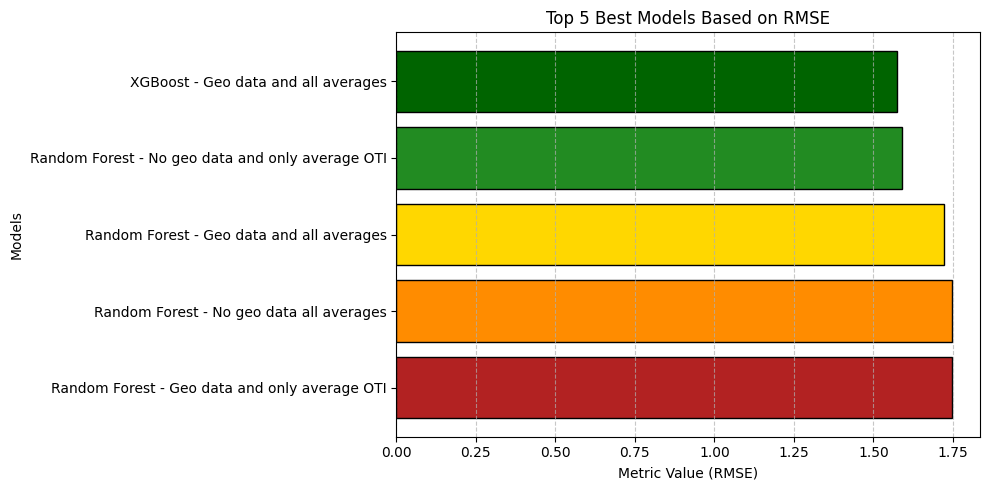

In [1595]:
K: int = 5

best_results = results_flatten[ranking][:K]
best_models = ranked_models[:K]

colors = ['#006400', '#228B22', '#FFD700', '#FF8C00', '#B22222']

plt.figure(figsize=(10, 5))

plt.barh(best_models, best_results, color=colors, edgecolor='black', linewidth=1)
plt.xlabel(f'Metric Value ({METRIC_NAME})')
plt.ylabel('Models')
plt.title(f'Top {K} Best Models Based on {METRIC_NAME}')
plt.gca().invert_yaxis()                                            # Invert y-axis to show the best model at the top
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(os.path.join(PLOT_PATH, f'top_{K}_models_based_on_{METRIC_NAME}.png'))
plt.show()

##### MAPE

In [1596]:
METRIC_NAME: str = 'MAPE'

In [1597]:
results_flatten = np.array([[eval.mape for eval in m] for m in results]).flatten()
ranking = np.argsort(results_flatten)

ranked_datasets_indexes = ranking // len(models[0])
ranked_models_indexes = ranking % len(models[0])

ranked_models = [f'{models[dataset_index][model_index]} - {datasets[dataset_index]}' for dataset_index, model_index in zip(ranked_datasets_indexes, ranked_models_indexes)]

print(f'Ranking of models based on {METRIC_NAME}:')
for i, model in enumerate(ranked_models):
    print(f'\t{model}: {results_flatten[ranking][i]}')

Ranking of models based on MAPE:
	XGBoost - Geo data and all averages: 0.3792732483293708
	XGBoost - No geo data all averages: 0.5782940701833341
	XGBoost - Geo data and only average OTI: 0.5782940701833341
	LightGBM - Geo data and all averages: 0.7370868428701774
	Random Forest - Geo data and only average OTI: 0.7621668372359072
	Random Forest - No geo data all averages: 0.7621668372359074
	Random Forest - Geo data and all averages: 0.7674945004815054
	Dummy model - No geo data all averages: 0.9643288464658275
	Dummy model - Geo data and only average OTI: 0.9643288464658275
	Dummy model - No geo data and only average OTI: 0.9643288464658275
	Dummy model - Geo data and all averages: 0.9643288464658275
	LightGBM - No geo data all averages: 1.0006671005044385
	LightGBM - Geo data and only average OTI: 1.0006671005044385
	Linear Regression - Geo data and only average OTI: 1.0046614269916423
	LightGBM - No geo data and only average OTI: 1.0227982174766752
	XGBoost - No geo data and only av

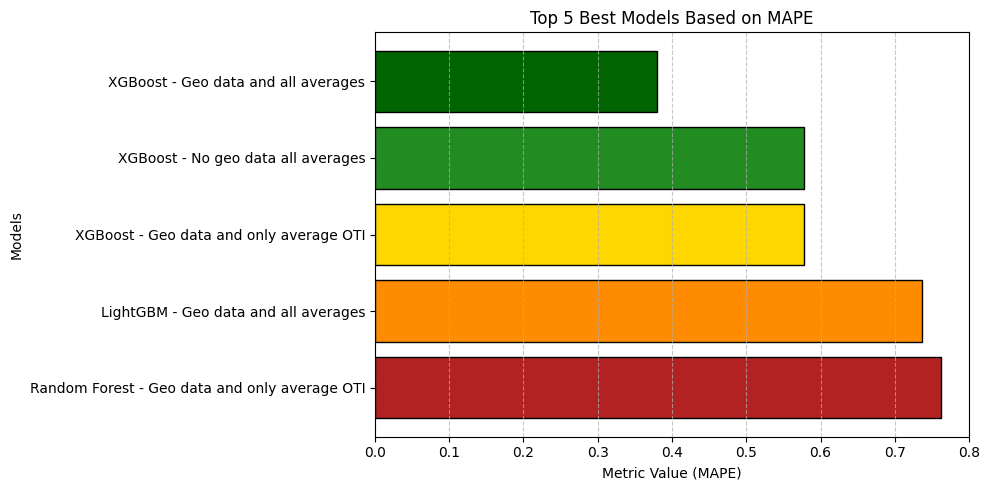

In [1598]:
K: int = 5

best_results = results_flatten[ranking][:K]
best_models = ranked_models[:K]

colors = ['#006400', '#228B22', '#FFD700', '#FF8C00', '#B22222']

plt.figure(figsize=(10, 5))

plt.barh(best_models, best_results, color=colors, edgecolor='black', linewidth=1)
plt.xlabel(f'Metric Value ({METRIC_NAME})')
plt.ylabel('Models')
plt.title(f'Top {K} Best Models Based on {METRIC_NAME}')
plt.gca().invert_yaxis()                                            # Invert y-axis to show the best model at the top
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(os.path.join(PLOT_PATH, f'top_{K}_models_based_on_{METRIC_NAME}.png'))
plt.show()

## Random Forest optimization

In [1663]:
import optuna

def objective_rf(trial, 
                 X_train: np.ndarray, y_train: np.ndarray, 
                 X_val: np.ndarray, y_val: np.ndarray, 
                 random_state: int = RANDOM_STATE) -> float:
    
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 10, 100),
        "max_depth": trial.suggest_int("max_depth", 6, 20),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
        "max_leaf_nodes": trial.suggest_int("max_leaf_nodes", 10, 50),
        "bootstrap": True,
        "max_samples": trial.suggest_float("max_samples", 0.3, 1.0),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", None]),
        "oob_score": True,
        "n_jobs": -1,
        "random_state": random_state,
        "criterion": "absolute_error",
    }

    X_train_val: np.ndarray = np.concatenate((X_train, X_val), axis=0)
    y_train_val: np.ndarray = np.concatenate((y_train, y_val), axis=0)

    model: RandomForestRegressor = RandomForestRegressor(**params)

    model.fit(X_train_val, y_train_val)
    y_pred: np.ndarray = model.predict(X_val)
    mae: float = MAE(y_val, y_pred)
    return mae

### Geo data and all averages

#### Dataset preparation

In [1664]:
X: pd.DataFrame = routes_df.loc[:, ['distance', 'avg_tmi', 'tmi', 'avg_wmi', 'wmi', 'avg_oti', 'time']]
y: pd.Series = X.pop('time')

X.head()

,distance,avg_tmi,tmi,avg_wmi,wmi,avg_oti
0,61.761066,0.000000,0.00000,0.224436,0.224436,3.683333
1,9381.875452,0.000000,0.00000,0.750000,0.750000,18.966667
2,564.352543,0.000000,0.00000,0.101561,0.101561,1.983333
3,664.754853,0.000000,0.00000,0.231342,0.119203,1.860000
4,46.277438,0.094904,0.14811,0.106983,0.103400,0.944792


In [1665]:
if AUGMENT_DATA:
    X_augmented: pd.DataFrame = augmented_routes_df.loc[:, ['distance', 'avg_tmi', 'tmi', 'avg_wmi', 'wmi', 'avg_oti', 'time']]
    y_augmented: pd.Series = X_augmented.pop('time')
else:
    X_augmented: pd.DataFrame = pd.DataFrame(columns=X.columns)
    y_augmented: pd.Series = pd.Series(dtype=float)

X_augmented.head()

,distance,avg_tmi,tmi,avg_wmi,wmi,avg_oti
0,9443.636517,0.000000,0.000000,0.746563,0.746563,22.650000
1,9946.227995,0.000000,0.000000,0.713207,0.713207,20.950000
2,1229.107397,0.000000,0.000000,0.171752,0.111102,3.843333
3,711.032292,0.006177,0.009640,0.223248,0.118174,2.804792
4,62.925407,0.069796,0.170181,0.078679,0.098869,3.941667


In [1666]:
splits: DataSplit = split_data(X, y)
if AUGMENT_DATA:
    splits = concat_augmented_data(splits, X_augmented, y_augmented)

trainable_splits: TrainableDataSplit = normalize_data(splits, normalize=False)
X_train, X_val, X_test = trainable_splits.X_train, trainable_splits.X_val, trainable_splits.X_test
print(f"X_train shape: {X_train.shape}, X_val shape: {X_val.shape}, X_test shape: {X_test.shape}")

X_train shape: (857, 6), X_val shape: (45, 6), X_test shape: (89, 6)


In [1667]:
y_train, y_val, y_test = trainable_splits.y_train, trainable_splits.y_val, trainable_splits.y_test
print(f"Train set shape: {y_train.shape}, Val set shape: {y_val.shape}, Test set shape: {y_test.shape}")

Train set shape: (857,), Val set shape: (45,), Test set shape: (89,)


#### Model

In [1668]:
study: optuna.Study = optuna.create_study(direction="minimize", study_name="Random Forest Hyperparameter Optimization")
study.optimize(lambda trial: objective_rf(trial, X_train, y_train, X_val, y_val), n_trials=200, timeout=60 * 5, n_jobs=-1)

print("Best trial:")
print(study.best_trial)

[I 2025-07-27 22:11:41,532] A new study created in memory with name: Random Forest Hyperparameter Optimization
[I 2025-07-27 22:11:42,512] Trial 6 finished with value: 0.8863756613756613 and parameters: {'n_estimators': 14, 'max_depth': 8, 'min_samples_split': 9, 'min_samples_leaf': 4, 'max_leaf_nodes': 35, 'max_samples': 0.6705650341319128, 'max_features': None}. Best is trial 6 with value: 0.8863756613756613.
[I 2025-07-27 22:11:42,516] Trial 5 finished with value: 1.0017305236270753 and parameters: {'n_estimators': 29, 'max_depth': 16, 'min_samples_split': 9, 'min_samples_leaf': 8, 'max_leaf_nodes': 25, 'max_samples': 0.5826882220049898, 'max_features': 'log2'}. Best is trial 6 with value: 0.8863756613756613.
[I 2025-07-27 22:11:43,089] Trial 4 finished with value: 0.9730501089324619 and parameters: {'n_estimators': 51, 'max_depth': 14, 'min_samples_split': 6, 'min_samples_leaf': 5, 'max_leaf_nodes': 31, 'max_samples': 0.9638454212835077, 'max_features': 'log2'}. Best is trial 6 wit

Best trial:
FrozenTrial(number=187, state=1, values=[0.7650617283950617], datetime_start=datetime.datetime(2025, 7, 27, 22, 13, 4, 150284), datetime_complete=datetime.datetime(2025, 7, 27, 22, 13, 6, 883142), params={'n_estimators': 12, 'max_depth': 16, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_leaf_nodes': 36, 'max_samples': 0.3391419113335256, 'max_features': None}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=100, log=False, low=10, step=1), 'max_depth': IntDistribution(high=20, log=False, low=6, step=1), 'min_samples_split': IntDistribution(high=10, log=False, low=2, step=1), 'min_samples_leaf': IntDistribution(high=10, log=False, low=1, step=1), 'max_leaf_nodes': IntDistribution(high=50, log=False, low=10, step=1), 'max_samples': FloatDistribution(high=1.0, log=False, low=0.3, step=None), 'max_features': CategoricalDistribution(choices=('sqrt', 'log2', None))}, trial_id=187, value=None)


In [1669]:
best_params: Dict[str, Any] = study.best_trial.params
best_params

{'n_estimators': 12,
 'max_depth': 16,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_leaf_nodes': 36,
 'max_samples': 0.3391419113335256,
 'max_features': None}

In [1670]:
opt_rf: RandomForestRegressor = RandomForestRegressor(
    **best_params,
    criterion='absolute_error',
    n_jobs=-1,
    random_state=RANDOM_STATE
)

X_train_val: np.ndarray = np.concatenate((X_train, X_val), axis=0)
y_train_val: np.ndarray = np.concatenate((y_train, y_val), axis=0)

opt_rf.fit(X_train_val, y_train_val)
opt_rf

,n_estimators,12
,criterion,'absolute_error'
,max_depth,16
,min_samples_split,5
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,max_leaf_nodes,36
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [1671]:
# Predict on the test set
y_pred_opt_rf = opt_rf.predict(X_test)

opt_rf_eval: EvaluationResult = evaluate_model(y_test, y_pred_opt_rf, RFR_MODEL_NAME, "Geo data and all averages")


Random Forest Results:
MAE: 1.1027
RMSE: 2.1194
MAPE: 0.4577
MSDP: 0.3110


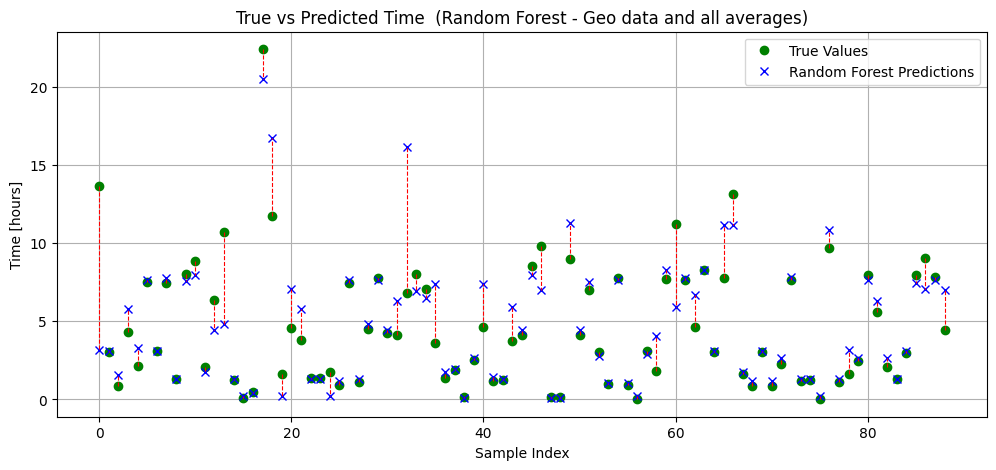

In [1672]:
plot_predictions(y_test, y_pred_opt_rf, RFR_MODEL_NAME, "Geo data and all averages")

## XGBoost optimization

In [1673]:
import optuna

def optimize_xgb(trial: optuna.Trial, 
                 X_train: np.ndarray, y_train: np.ndarray,
                 X_val: np.ndarray, y_val: np.ndarray, 
                 random_state: int = RANDOM_STATE) -> float:
    
    # Create the DMatrix for XGBoost
    dtrain = DMatrix(X_train, label=y_train)
    dval = DMatrix(X_val, label=y_val)

    params: Dict[str, Any] = {
        'objective': 'reg:absoluteerror',
        'booster': 'gbtree',
        'max_depth': trial.suggest_int('max_depth', 6, 15),
        'min_child_weight': trial.suggest_float('min_child_weight', 1, 15),
        'gamma': trial.suggest_float('gamma', 0, 1),
        'eta': trial.suggest_float('eta', 0.01, 0.5, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'lambda': trial.suggest_float('lambda', 1e-3, 5.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-3, 5.0, log=True),
        'seed': random_state,
        'verbosity': 0
    }

    # Train the model
    evals_result: Dict = {}
    model: Booster = xgb_train(
        params, 
        dtrain, 
        num_boost_round=1000, 
        evals=[(dval, "eval")], 
        early_stopping_rounds=50, 
        evals_result=evals_result,
        verbose_eval=False
    )
    preds = model.predict(dval)
    mae: float = MAE(y_val, preds)
    return mae

### Geo data and only average oti

#### Dataset preparation

In [1674]:
X: pd.DataFrame = routes_df.loc[:, ['distance', 'wmi', 'tmi', 'avg_oti', 'time']]
y: pd.Series = X.pop('time')

X.head()

,distance,wmi,tmi,avg_oti
0,61.761066,0.224436,0.00000,3.683333
1,9381.875452,0.750000,0.00000,18.966667
2,564.352543,0.101561,0.00000,1.983333
3,664.754853,0.119203,0.00000,1.860000
4,46.277438,0.103400,0.14811,0.944792


In [1675]:
if AUGMENT_DATA:
    X_augmented: pd.DataFrame = augmented_routes_df.loc[:, ['distance', 'wmi', 'tmi', 'avg_oti', 'time']]
    y_augmented: pd.Series = X_augmented.pop('time')
else:
    X_augmented: pd.DataFrame = pd.DataFrame(columns=X.columns)
    y_augmented: pd.Series = pd.Series(dtype=float)

X_augmented.head()

,distance,wmi,tmi,avg_oti
0,9443.636517,0.746563,0.000000,22.650000
1,9946.227995,0.713207,0.000000,20.950000
2,1229.107397,0.111102,0.000000,3.843333
3,711.032292,0.118174,0.009640,2.804792
4,62.925407,0.098869,0.170181,3.941667


In [1676]:
splits: DataSplit = split_data(X, y)
if AUGMENT_DATA:
    splits = concat_augmented_data(splits, X_augmented, y_augmented)

trainable_splits: TrainableDataSplit = normalize_data(splits, normalize=False)
X_train, X_val, X_test = trainable_splits.X_train, trainable_splits.X_val, trainable_splits.X_test
print(f"X_train shape: {X_train.shape}, X_val shape: {X_val.shape}, X_test shape: {X_test.shape}")

X_train shape: (857, 4), X_val shape: (45, 4), X_test shape: (89, 4)


In [1677]:
y_train, y_val, y_test = trainable_splits.y_train, trainable_splits.y_val, trainable_splits.y_test
print(f"Train set shape: {y_train.shape}, Val set shape: {y_val.shape}, Test set shape: {y_test.shape}")

Train set shape: (857,), Val set shape: (45,), Test set shape: (89,)


#### Model

In [1678]:
study: optuna.Study = optuna.create_study(direction="minimize", study_name="XGBoost Hyperparameter Optimization")
study.optimize(lambda trial: optimize_xgb(trial, X_train, y_train, X_val, y_val), n_trials=200, timeout=60 * 5, n_jobs=-1)

print("Best trial:")
print(study.best_trial)

[I 2025-07-27 22:13:11,652] A new study created in memory with name: XGBoost Hyperparameter Optimization
[I 2025-07-27 22:13:12,578] Trial 0 finished with value: 1.1127041484498317 and parameters: {'max_depth': 7, 'min_child_weight': 9.868894641227769, 'gamma': 0.352436953880511, 'eta': 0.36705685945475436, 'subsample': 0.729592550103489, 'colsample_bytree': 0.8729856549033441, 'lambda': 0.42509123377957575, 'alpha': 0.06392689362728235}. Best is trial 0 with value: 1.1127041484498317.
[I 2025-07-27 22:13:12,621] Trial 2 finished with value: 0.9938079000264407 and parameters: {'max_depth': 7, 'min_child_weight': 5.8779986007696525, 'gamma': 0.44138274455383086, 'eta': 0.29743549961062143, 'subsample': 0.8259144979210016, 'colsample_bytree': 0.789423256286527, 'lambda': 0.8234552376799612, 'alpha': 1.1169645134224215}. Best is trial 2 with value: 0.9938079000264407.
[I 2025-07-27 22:13:14,725] Trial 9 finished with value: 0.9823916977019637 and parameters: {'max_depth': 9, 'min_child_we

Best trial:
FrozenTrial(number=129, state=1, values=[0.7885375505796186], datetime_start=datetime.datetime(2025, 7, 27, 22, 14, 27, 815741), datetime_complete=datetime.datetime(2025, 7, 27, 22, 14, 29, 710172), params={'max_depth': 11, 'min_child_weight': 11.24033746483083, 'gamma': 0.3818349541677885, 'eta': 0.2245023109018262, 'subsample': 0.9714267624765731, 'colsample_bytree': 0.7235370497387553, 'lambda': 2.1101601413174635, 'alpha': 0.015126871895506459}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'max_depth': IntDistribution(high=15, log=False, low=6, step=1), 'min_child_weight': FloatDistribution(high=15.0, log=False, low=1.0, step=None), 'gamma': FloatDistribution(high=1.0, log=False, low=0.0, step=None), 'eta': FloatDistribution(high=0.5, log=True, low=0.01, step=None), 'subsample': FloatDistribution(high=1.0, log=False, low=0.6, step=None), 'colsample_bytree': FloatDistribution(high=1.0, log=False, low=0.6, step=None), 'lambda': FloatDistribution(

In [1679]:
best_params: Dict[str, Any] = study.best_trial.params
best_params.update({
    'objective': 'reg:absoluteerror',
    'booster': 'gbtree',
    'seed': RANDOM_STATE
})

best_params

{'max_depth': 11,
 'min_child_weight': 11.24033746483083,
 'gamma': 0.3818349541677885,
 'eta': 0.2245023109018262,
 'subsample': 0.9714267624765731,
 'colsample_bytree': 0.7235370497387553,
 'lambda': 2.1101601413174635,
 'alpha': 0.015126871895506459,
 'objective': 'reg:absoluteerror',
 'booster': 'gbtree',
 'seed': 23}

In [1680]:
opt_xgb_1: Booster = xgb_train(
    best_params,
    DMatrix(np.concatenate([X_train, X_val]), label=np.concatenate([y_train, y_val])),
    num_boost_round=study.best_trial.number
)

opt_xgb_1

In [1681]:
dtest = DMatrix(X_test, label=y_test)

# Predict on the test set
y_pred_opt_xgb_1 = opt_xgb_1.predict(dtest)

opt_xgb_eval_1: EvaluationResult = evaluate_model(y_test, y_pred_opt_xgb_1, XGB_MODEL_NAME, "Geo data and only average OTI")


XGBoost Results:
MAE: 0.9848
RMSE: 1.8158
MAPE: 0.7357
MSDP: 0.5752


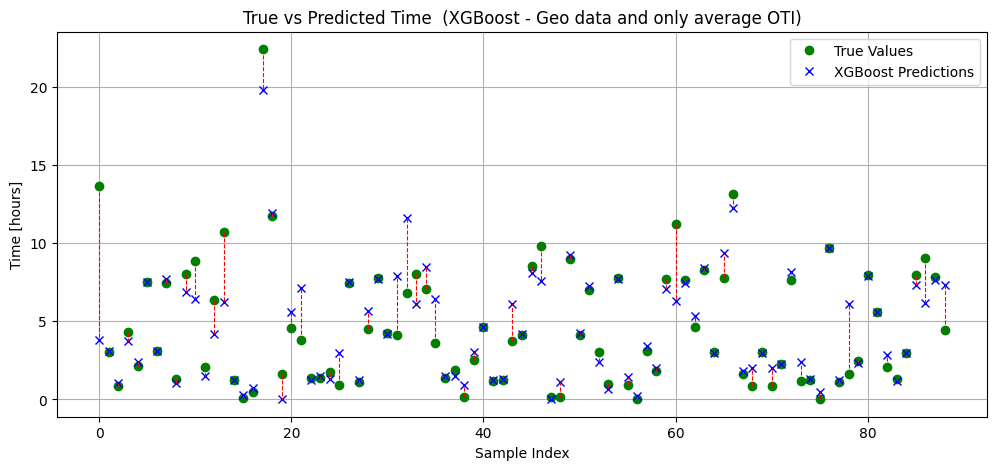

In [1682]:
plot_predictions(y_test, y_pred_opt_xgb_1, XGB_MODEL_NAME, "Geo data and only average OTI")

### Geo data and all averages

#### Dataset preparation

In [1683]:
X: pd.DataFrame = routes_df.loc[:, ['distance', 'avg_tmi', 'tmi', 'avg_wmi', 'wmi', 'avg_oti', 'time']]
y: pd.Series = X.pop('time')

X.head()

,distance,avg_tmi,tmi,avg_wmi,wmi,avg_oti
0,61.761066,0.000000,0.00000,0.224436,0.224436,3.683333
1,9381.875452,0.000000,0.00000,0.750000,0.750000,18.966667
2,564.352543,0.000000,0.00000,0.101561,0.101561,1.983333
3,664.754853,0.000000,0.00000,0.231342,0.119203,1.860000
4,46.277438,0.094904,0.14811,0.106983,0.103400,0.944792


In [1684]:
if AUGMENT_DATA:
    X_augmented: pd.DataFrame = augmented_routes_df.loc[:, ['distance', 'avg_tmi', 'tmi', 'avg_wmi', 'wmi', 'avg_oti', 'time']]
    y_augmented: pd.Series = X_augmented.pop('time')
else:
    X_augmented: pd.DataFrame = pd.DataFrame(columns=X.columns)
    y_augmented: pd.Series = pd.Series(dtype=float)

X_augmented.head()

,distance,avg_tmi,tmi,avg_wmi,wmi,avg_oti
0,9443.636517,0.000000,0.000000,0.746563,0.746563,22.650000
1,9946.227995,0.000000,0.000000,0.713207,0.713207,20.950000
2,1229.107397,0.000000,0.000000,0.171752,0.111102,3.843333
3,711.032292,0.006177,0.009640,0.223248,0.118174,2.804792
4,62.925407,0.069796,0.170181,0.078679,0.098869,3.941667


In [1685]:
splits: DataSplit = split_data(X, y)
if AUGMENT_DATA:
    splits = concat_augmented_data(splits, X_augmented, y_augmented)

trainable_splits: TrainableDataSplit = normalize_data(splits, normalize=False)
X_train, X_val, X_test = trainable_splits.X_train, trainable_splits.X_val, trainable_splits.X_test
print(f"X_train shape: {X_train.shape}, X_val shape: {X_val.shape}, X_test shape: {X_test.shape}")

X_train shape: (857, 6), X_val shape: (45, 6), X_test shape: (89, 6)


In [1686]:
y_train, y_val, y_test = trainable_splits.y_train, trainable_splits.y_val, trainable_splits.y_test
print(f"Train set shape: {y_train.shape}, Val set shape: {y_val.shape}, Test set shape: {y_test.shape}")

Train set shape: (857,), Val set shape: (45,), Test set shape: (89,)


#### Model

In [1687]:
study: optuna.Study = optuna.create_study(direction="minimize", study_name="XGBoost Hyperparameter Optimization")
study.optimize(lambda trial: optimize_xgb(trial, X_train, y_train, X_val, y_val), n_trials=200, timeout=60 * 5, n_jobs=-1)

print("Best trial:")
print(study.best_trial)

[I 2025-07-27 22:14:47,441] A new study created in memory with name: XGBoost Hyperparameter Optimization
[I 2025-07-27 22:14:48,453] Trial 5 finished with value: 0.9101055380812398 and parameters: {'max_depth': 7, 'min_child_weight': 12.499494633423087, 'gamma': 0.6781637368109292, 'eta': 0.1630053418428401, 'subsample': 0.7609250389664881, 'colsample_bytree': 0.9392302626597677, 'lambda': 0.6736189048159343, 'alpha': 0.00429065953046104}. Best is trial 5 with value: 0.9101055380812398.
[I 2025-07-27 22:14:48,498] Trial 7 finished with value: 1.009378962053193 and parameters: {'max_depth': 12, 'min_child_weight': 9.256443370233072, 'gamma': 0.9124790159590187, 'eta': 0.26303548864026316, 'subsample': 0.63210126913069, 'colsample_bytree': 0.8037505839677046, 'lambda': 0.00712253564378977, 'alpha': 0.011692569533813384}. Best is trial 5 with value: 0.9101055380812398.
[I 2025-07-27 22:14:48,889] Trial 1 finished with value: 1.019850658772996 and parameters: {'max_depth': 12, 'min_child_w

Best trial:
FrozenTrial(number=134, state=1, values=[0.7364860479271523], datetime_start=datetime.datetime(2025, 7, 27, 22, 15, 39, 209825), datetime_complete=datetime.datetime(2025, 7, 27, 22, 15, 40, 432885), params={'max_depth': 6, 'min_child_weight': 14.652132092469543, 'gamma': 0.6101219690390559, 'eta': 0.40006689151465835, 'subsample': 0.970909503304265, 'colsample_bytree': 0.8516851245493918, 'lambda': 0.7654977670836138, 'alpha': 0.8451028488867774}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'max_depth': IntDistribution(high=15, log=False, low=6, step=1), 'min_child_weight': FloatDistribution(high=15.0, log=False, low=1.0, step=None), 'gamma': FloatDistribution(high=1.0, log=False, low=0.0, step=None), 'eta': FloatDistribution(high=0.5, log=True, low=0.01, step=None), 'subsample': FloatDistribution(high=1.0, log=False, low=0.6, step=None), 'colsample_bytree': FloatDistribution(high=1.0, log=False, low=0.6, step=None), 'lambda': FloatDistribution(hi

In [1688]:
best_params: Dict[str, Any] = study.best_trial.params
best_params.update({
    'objective': 'reg:absoluteerror',
    'booster': 'gbtree',
    'seed': RANDOM_STATE
})

best_params

{'max_depth': 6,
 'min_child_weight': 14.652132092469543,
 'gamma': 0.6101219690390559,
 'eta': 0.40006689151465835,
 'subsample': 0.970909503304265,
 'colsample_bytree': 0.8516851245493918,
 'lambda': 0.7654977670836138,
 'alpha': 0.8451028488867774,
 'objective': 'reg:absoluteerror',
 'booster': 'gbtree',
 'seed': 23}

In [1689]:
opt_xgb_2: Booster = xgb_train(
    best_params,
    DMatrix(np.concatenate([X_train, X_val]), label=np.concatenate([y_train, y_val])),
    num_boost_round=study.best_trial.number
)

opt_xgb_2

In [1690]:
dtest = DMatrix(X_test, label=y_test)

# Predict on the test set
y_pred_opt_xgb_2 = opt_xgb_2.predict(dtest)

opt_xgb_eval_2: EvaluationResult = evaluate_model(y_test, y_pred_opt_xgb_2, XGB_MODEL_NAME, "Geo data and all averages")


XGBoost Results:
MAE: 0.9950
RMSE: 1.7657
MAPE: 0.6780
MSDP: 0.4979


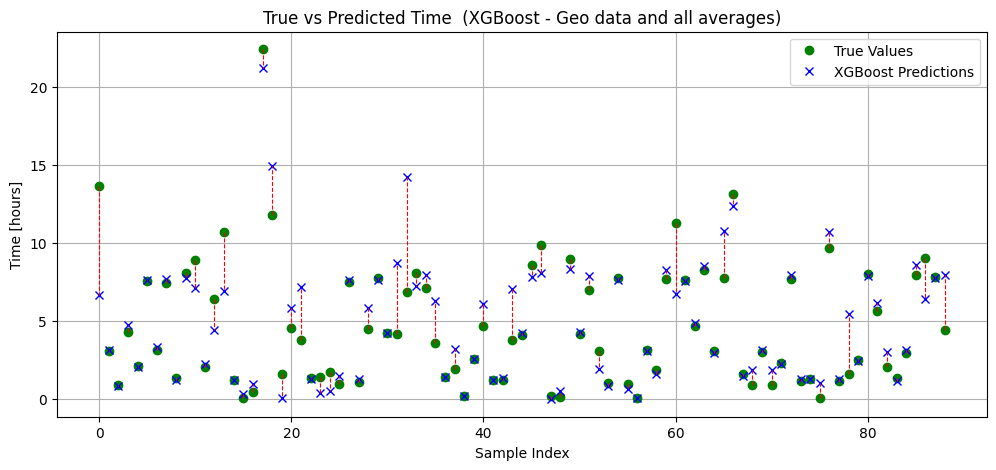

In [1691]:
plot_predictions(y_test, y_pred_opt_xgb_2, XGB_MODEL_NAME, "Geo data and all averages")

### Final model

#### Dataset preparation

In [1692]:
X: pd.DataFrame = routes_df.loc[:, ['distance', 'tmi', 'avg_tmi', 'wmi', 'avg_wmi', 'avg_oti', 'time']]
y: pd.Series = X.pop('time')

X.head()

,distance,tmi,avg_tmi,wmi,avg_wmi,avg_oti
0,61.761066,0.00000,0.000000,0.224436,0.224436,3.683333
1,9381.875452,0.00000,0.000000,0.750000,0.750000,18.966667
2,564.352543,0.00000,0.000000,0.101561,0.101561,1.983333
3,664.754853,0.00000,0.000000,0.119203,0.231342,1.860000
4,46.277438,0.14811,0.094904,0.103400,0.106983,0.944792


In [1693]:
if AUGMENT_DATA:
    X_augmented: pd.DataFrame = augmented_routes_df.loc[:, ['distance', 'tmi', 'avg_tmi', 'wmi', 'avg_wmi', 'avg_oti', 'time']]
    y_augmented: pd.Series = X_augmented.pop('time')
else:
    X_augmented: pd.DataFrame = pd.DataFrame(columns=X.columns)
    y_augmented: pd.Series = pd.Series(dtype=float)

X_augmented.head()

,distance,tmi,avg_tmi,wmi,avg_wmi,avg_oti
0,9443.636517,0.000000,0.000000,0.746563,0.746563,22.650000
1,9946.227995,0.000000,0.000000,0.713207,0.713207,20.950000
2,1229.107397,0.000000,0.000000,0.111102,0.171752,3.843333
3,711.032292,0.009640,0.006177,0.118174,0.223248,2.804792
4,62.925407,0.170181,0.069796,0.098869,0.078679,3.941667


In [1694]:
splits: DataSplit = split_data(X, y)
if AUGMENT_DATA:
    splits = concat_augmented_data(splits, X_augmented, y_augmented)

trainable_splits: TrainableDataSplit = normalize_data(splits, normalize=False)
X_train, X_val, X_test = trainable_splits.X_train, trainable_splits.X_val, trainable_splits.X_test
print(f"X_train shape: {X_train.shape}, X_val shape: {X_val.shape}, X_test shape: {X_test.shape}")

X_train shape: (857, 6), X_val shape: (45, 6), X_test shape: (89, 6)


In [1695]:
y_train, y_val, y_test = trainable_splits.y_train, trainable_splits.y_val, trainable_splits.y_test
print(f"Train set shape: {y_train.shape}, Val set shape: {y_val.shape}, Test set shape: {y_test.shape}")

Train set shape: (857,), Val set shape: (45,), Test set shape: (89,)


#### Model

In [1696]:
xgb_final: Booster = train_xgb(X_train, y_train, X_val, y_val, random_state=RANDOM_STATE)

best_score: float = xgb_final.best_score
best_iterations: int = xgb_final.best_iteration

xgb_final, xgb_final.best_score, best_iterations

[0]	eval-mae:3.53578
[1]	eval-mae:3.20740
[2]	eval-mae:2.93914
[3]	eval-mae:2.68753
[4]	eval-mae:2.48458
[5]	eval-mae:2.30428
[6]	eval-mae:2.11982
[7]	eval-mae:1.97168
[8]	eval-mae:1.86123
[9]	eval-mae:1.71315
[10]	eval-mae:1.60230
[11]	eval-mae:1.51318
[12]	eval-mae:1.44502
[13]	eval-mae:1.38115
[14]	eval-mae:1.33634
[15]	eval-mae:1.27694
[16]	eval-mae:1.23996
[17]	eval-mae:1.19271
[18]	eval-mae:1.16292
[19]	eval-mae:1.14164
[20]	eval-mae:1.11857
[21]	eval-mae:1.09689
[22]	eval-mae:1.07638
[23]	eval-mae:1.07819
[24]	eval-mae:1.06290
[25]	eval-mae:1.05034
[26]	eval-mae:1.03707
[27]	eval-mae:1.02770
[28]	eval-mae:1.01838
[29]	eval-mae:1.01167
[30]	eval-mae:1.00462
[31]	eval-mae:0.99601
[32]	eval-mae:0.99121
[33]	eval-mae:0.98696
[34]	eval-mae:0.98600
[35]	eval-mae:0.98009
[36]	eval-mae:0.97794
[37]	eval-mae:0.97640
[38]	eval-mae:0.97397
[39]	eval-mae:0.97424
[40]	eval-mae:0.97305
[41]	eval-mae:0.97306
[42]	eval-mae:0.97141
[43]	eval-mae:0.97067
[44]	eval-mae:0.97351
[45]	eval-mae:0.9744

(<xgboost.core.Booster at 0x258408f51d0>, 0.9550366304814816, 64)

In [1697]:
dtest = DMatrix(X_test, label=y_test)

# Predict on the test set
y_pred = xgb_final.predict(dtest)

xgb_eval: EvaluationResult = evaluate_model(y_test, y_pred, XGB_MODEL_NAME, "Geo data and only average OTI")


XGBoost Results:
MAE: 0.8464
RMSE: 1.5737
MAPE: 0.3793
MSDP: 0.1170


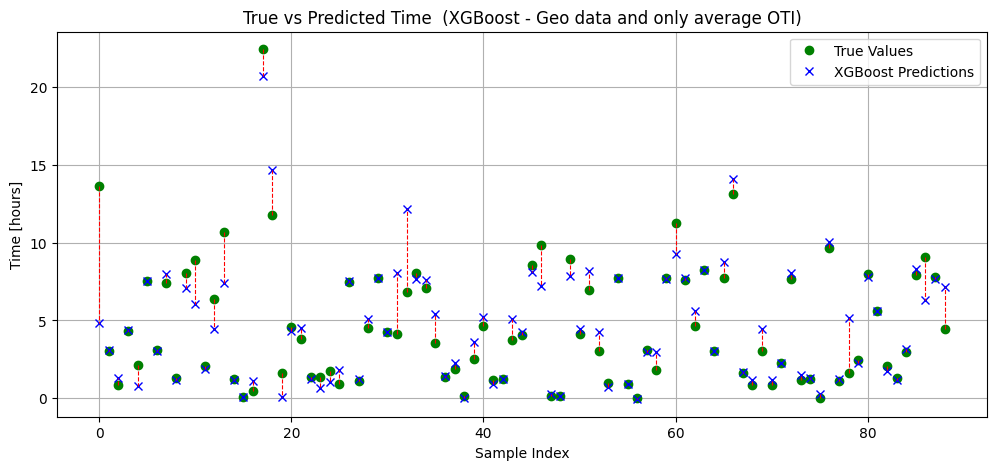

In [1698]:
plot_predictions(y_test, y_pred, XGB_MODEL_NAME, "Geo data and only average OTI")

#### Final training with test set:

In [1699]:
X_all = np.concatenate([X_train, X_val, X_test])
y_all = np.concatenate([y_train, y_val, y_test])

dtrain = DMatrix(X_all, label=y_all)

params = {
    'objective': 'reg:absoluteerror',
    'booster': 'gbtree',                # gbtree, gblinear or dart
    'max_depth': 8,                     # Maximum depth of a tree
    'min_child_weight': 3,              # Minimum sum of instance weight (hessian) needed in a child.
    'gamma': 0.1,                       # Minimum loss reduction required to make a further partition on a leaf node of the tree.
    'eta': 0.1,                         # Learning rate
    'subsample': 0.8,                   # Subsample ratio of the training instances.
    'colsample_bytree': 0.8,            # Subsample ratio of columns when constructing each tree.
    'lambda': 0.1,                      # L2 regularization term on weights
    'alpha': 0.0,                       # L1 regularization term on weights
    'seed': RANDOM_STATE,               # Random seed for reproducibility
}

# Train the model
xgb_final: Booster = xgb_train(params, dtrain, best_iterations + 5)
xgb_final

In [1700]:
xgb_final.save_model(os.path.join(MODEL_PATH, f"rt_estimator_{XGB_MODEL_NAME.lower()}.json"))

In [1701]:
import xgboost as xgb 

with open(os.path.join(MODEL_PATH, f"rt_estimator_{XGB_MODEL_NAME.lower()}.json"), 'r') as f:
    model_json_str = f.read()

# Create booster and load directly from the JSON string
booster = xgb.Booster()
booster.load_model(bytearray(model_json_str, 'utf-8'))

booster